In [1]:
import pandas as pd
import numpy as np
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from datetime import datetime
import tensorflow as tf

/opt/homebrew/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_17060/3878954045.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [129]:
def calculate_rsi(prices, window=40):
    # Calculate the price differences
    delta = prices.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=window, min_periods=40).mean()
    avg_loss = loss.rolling(window=window, min_periods=40).mean()

    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

def transform_prices(df, window=60):
    df['Returns'] = df['Close'].pct_change()    
    df['MovingAverage'] = df['Close'].rolling(window=60).mean()
    df['Volatility'] = df['Returns'].rolling(window=60).std() * np.sqrt(60)
    df['RSI'] = calculate_rsi(df['Close'])

    # Creating the momentum feature
    df['Momentum'] = df['Close'] - df['MovingAverage']
    df['Momentum'] /= df['MovingAverage'] * df['Volatility']

    # Droping features which the function should not append
    df = df.drop(columns=['MovingAverage'])
    df = df.dropna()

    return df
    
def get_data(start_date, end_date):
    print(start_date, end_date,'**')
    data = pd.read_csv('full_data.csv')
    data['Date'] = pd.to_datetime(data['Date'])

    btc = data.loc[data['Crypto']=='BTC']
    btc = btc.drop('Unnamed: 0', axis=1)
    btc = btc.sort_values(by='Date')
    btc = btc.reset_index(drop=True)
    btc = btc.drop(['Crypto'],axis=1)
    btc = btc.set_index('Date')

    #train for optimization only till then
    btc = btc.loc[(btc.index>=start_date) & (btc.index < end_date)]
    btc = transform_prices(btc)

    return btc 

In [130]:
#function to split X
def ts_split(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    return X
# Forecasting target t+n days ahead
def ts_split_y(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    y = np.array([ts[idx + feature_steps + target_steps - 1]
                  for idx in range(n_obs)])
    return y

In [131]:
def get_x_features(start_date, end_date, value_features):
    btc = get_data(start_date, end_date)
    value_features = value_features #we use last 60 days 
    value_target = 5 #to forecast 5 days ahead
    #split the data for all 3 assets
    btc_open = ts_split(np.array(btc['Open']), feature_steps = value_features, target_steps = value_target)
    btc_high = ts_split(np.array(btc['High']), feature_steps = value_features, target_steps = value_target)
    btc_low = ts_split(np.array(btc['Low']), feature_steps = value_features, target_steps = value_target)
    btc_close = ts_split(np.array(btc['Close']), feature_steps = value_features, target_steps = value_target)
    btc_ret = ts_split(np.array(btc['Returns']), feature_steps = value_features, target_steps = value_target)
    btc_vol = ts_split(np.array(btc['Volatility']), feature_steps = value_features, target_steps = value_target)
    btc_rsi = ts_split(np.array(btc['RSI']), feature_steps = value_features, target_steps = value_target)
    btc_mom = ts_split(np.array(btc['Momentum']), feature_steps = value_features, target_steps = value_target)

    #Target var of predicting price t+n days ahead
    y_btc = ts_split_y(np.array(btc['Close']), feature_steps = value_features, target_steps = value_target)

    #create the features matrix
    combined_array = np.stack((btc_open, btc_high , btc_low, btc_close, btc_ret, btc_vol, btc_rsi, btc_mom), axis=1)
    X = combined_array

    # Determine the size of the validation set
    train_idx = round(len(X)*0.8)
    X_train_full= X[:train_idx] ## all same for each model

    #test data for X and y targets
    X_test= X[train_idx:]
    y_test_btc = y_btc[train_idx:]

    val_idx = round(train_idx * 0.1)  # 10% of the training set
    train_idx_final = train_idx - val_idx

    # Split the training data into training and validation sets
    X_train = X_train_full[:train_idx_final]
    X_val = X_train_full[train_idx_final:train_idx]

    #train and validation for targets
    y_train_btc = y_btc[:train_idx_final]
    y_val_btc = y_btc[train_idx_final:train_idx]

    #reshape and convert all into pandas series
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_train_reshaped = pd.DataFrame(X_train_reshaped)
    X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
    X_val_reshaped = pd.DataFrame(X_val_reshaped)

    y_train_btc = pd.DataFrame(y_train_btc)
    y_val_btc = pd.DataFrame(y_val_btc)

    #reshape  test
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    X_test_reshaped = pd.DataFrame(X_test_reshaped)

    y_test_btc_reshaped = y_test_btc.reshape(y_test_btc.shape[0], -1)
    y_test_btc_reshaped = pd.DataFrame(y_test_btc_reshaped)

    return X_train_reshaped, y_train_btc, X_val_reshaped, y_val_btc, X_test_reshaped, y_test_btc

In [165]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.initializers import HeNormal
from sklearn.preprocessing import StandardScaler

def create_model(start_date, end_date, value_features):
    print('in', value_features)
    X_train_reshaped, y_train_btc, X_val_reshaped, y_val_btc, X_test_reshaped, y_test_btc = get_x_features(start_date, end_date, value_features)
    # Initialize the StandardScaler
    scaler = StandardScaler()
    initializer = HeNormal()

    # Fit the scaler on the training data and transform both the training and validation data
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_val_scaled = scaler.transform(X_val_reshaped)
    X_test_scaled = scaler.transform(X_test_reshaped)

    # Function to reset the TensorFlow session
    def reset_session(seed=42):
        tf.keras.backend.clear_session()
        tf.compat.v1.reset_default_graph()
        tf.random.set_seed(seed)
        np.random.seed(seed)

    # Reset the session
    reset_session()
    neurons = 15
    activation = "swish"
    l2_reg = 0.07815802051981617
    # Define the DNN model
    model = Sequential([
        Dense(nuerons, activation=activation, input_shape=(X_train_scaled.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),

        Dense(1)
    ])
    optimizer = Nadam(learning_rate=0.003271730054012538)
    model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])

    # Train the model
    history = model.fit(X_train_scaled, y_train_btc, epochs=30, validation_data=(X_val_scaled, y_val_btc))
    y_test_pred = model.predict(X_test_scaled)
    prediction_accuracy = np.mean(np.sign(pd.DataFrame(y_test_pred).diff().dropna()) == np.sign(pd.DataFrame(y_test_btc).diff().dropna()))
    
    return float(prediction_accuracy)

In [166]:
from datetime import timedelta

def walk_forward(start_date, end_date, period_length):
    #start 3/1, end 3/5
    #metrics
    metrics = {
        'train_start': [], 'train_end': [], 'test_start': [], 'test_end': [],
        'feature_val': [], 'Prediction Accuracy': []
    }
    feature_vals = np.arange(10,90,5)
    #train start date
    train_start = start_date
    while train_start + timedelta(days=period_length*2) <= end_date: 
        train_end = train_start + timedelta(days=period_length) #end of train date
        test_start = train_end #start of test date
        test_end = test_start + timedelta(days=period_length) #end of test start
        best_feature = None
        best_accuracy = -1
        for feature_val in feature_vals: #iterate through the sigmas
            train_accuracy = create_model(train_start, train_end, feature_val) #run backtest on the training data
            if train_accuracy > best_accuracy: #update best profit and best sigma
                best_accuracy = train_accuracy
                best_feature = feature_val
        test_accuracy = create_model(test_start, test_end, best_feature) #run backtest on test data with best sigma from training run
        metrics['train_start'].append(train_start)
        metrics['train_end'].append(train_end)
        metrics['test_start'].append(test_start)
        metrics['test_end'].append(test_end)
        metrics['feature_val'].append(best_feature)
        metrics['Prediction Accuracy'].append(test_accuracy)
        
        train_start += timedelta(days=period_length)

    return pd.DataFrame(metrics)

In [167]:
start_date = datetime(2018, 1, 1)
end_date = datetime(2022, 5, 31)
period_length = 200
df = walk_forward(start_date, end_date, period_length)

in 10
2018-01-01 00:00:00 2018-07-20 00:00:00 **
Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 65871792.0000 - mse: 65871708.0000 - val_loss: 41721864.0000 - val_mse: 41721784.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 65631944.0000 - mse: 65631864.0000 - val_loss: 34070572.0000 - val_mse: 34070492.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 60463892.0000 - mse: 60463812.0000 - val_loss: 10922446.0000 - val_mse: 10922370.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 36749608.0000 - mse: 36749528.0000 - val_loss: 38884992.0000 - val_mse: 38884908.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 21701548.0000 - mse: 21701476.0000 - val_loss: 49578164.0000 - val_mse: 49578080.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15898136.0000 - mse: 15898060.0000 - val_loss: 36847944.0000 - val_mse: 36847860.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13434952.0000 - mse: 13434876.0000 - val_loss: 38850060.0000 - val_mse: 38849976.0000
Epoch 8/30
3/3 

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 49316616.0000 - mse: 49316544.0000 - val_loss: 33620068.0000 - val_mse: 33619992.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 31094368.0000 - mse: 31094300.0000 - val_loss: 32923462.0000 - val_mse: 32923398.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26042340.0000 - mse: 26042276.0000 - val_loss: 31967434.0000 - val_mse: 31967370.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21629160.0000 - mse: 21629096.0000 - val_loss: 32173590.0000 - val_mse: 32173526.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18698452.0000 - mse: 18698388.0000 - val_loss: 30973760.0000 - val_mse: 30973696.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17233392.0000 - mse: 17233330.0000 - val_loss: 24012812.0000 - val_mse: 24012748.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16067244.0000 - mse: 16067180.0000 - val_loss: 19047776.0000 - val_mse: 19047712.0000
Epoch 8/30
3/3 

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 64423392.0000 - mse: 64423304.0000 - val_loss: 41067536.0000 - val_mse: 41067448.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 64333344.0000 - mse: 64333256.0000 - val_loss: 39207960.0000 - val_mse: 39207872.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 61304072.0000 - mse: 61303980.0000 - val_loss: 5093933.5000 - val_mse: 5093854.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36931600.0000 - mse: 36931512.0000 - val_loss: 10125795.0000 - val_mse: 10125715.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17740376.0000 - mse: 17740300.0000 - val_loss: 28395552.0000 - val_mse: 28395478.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10951656.0000 - mse: 10951576.0000 - val_loss: 30021518.0000 - val_mse: 30021444.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8982264.0000 - mse: 8982184.0000 - val_loss: 31521898.0000 - val_mse: 31521824.0000
Epoch 8/

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 63815368.0000 - mse: 63815292.0000 - val_loss: 40444488.0000 - val_mse: 40444412.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63619612.0000 - mse: 63619536.0000 - val_loss: 40410284.0000 - val_mse: 40410208.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63606232.0000 - mse: 63606156.0000 - val_loss: 40380520.0000 - val_mse: 40380444.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63596764.0000 - mse: 63596688.0000 - val_loss: 40358072.0000 - val_mse: 40357996.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63594296.0000 - mse: 63594220.0000 - val_loss: 40350440.0000 - val_mse: 40350364.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63590032.0000 - mse: 63589956.0000 - val_loss: 40354636.0000 - val_mse: 40354560.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 59320048.0000 - mse: 59319968.0000 - val_loss: 40366120.0000 - val_mse: 40366044.0000
Epoc

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 64017252.0000 - mse: 64017184.0000 - val_loss: 38658136.0000 - val_mse: 38658064.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63635888.0000 - mse: 63635816.0000 - val_loss: 38319144.0000 - val_mse: 38319072.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 57184568.0000 - mse: 57184492.0000 - val_loss: 11823428.0000 - val_mse: 11823370.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30028216.0000 - mse: 30028154.0000 - val_loss: 812987.2500 - val_mse: 812929.1250
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17893770.0000 - mse: 17893712.0000 - val_loss: 3678038.5000 - val_mse: 3677980.7500
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13061723.0000 - mse: 13061665.0000 - val_loss: 9271522.0000 - val_mse: 9271464.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9745420.0000 - mse: 9745362.0000 - val_loss: 25385390.0000 - val_mse: 25385332.0000
Epoch 8/30
3/3 ━━━━━━━━━━

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 66120432.0000 - mse: 66120368.0000 - val_loss: 36847524.0000 - val_mse: 36847448.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 60920592.0000 - mse: 60920512.0000 - val_loss: 5943821.5000 - val_mse: 5943761.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23022102.0000 - mse: 23022040.0000 - val_loss: 4160015.2500 - val_mse: 4159952.7500
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11617860.0000 - mse: 11617799.0000 - val_loss: 9969697.0000 - val_mse: 9969636.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3948836.5000 - mse: 3948775.2500 - val_loss: 13633920.0000 - val_mse: 13633859.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3097935.5000 - mse: 3097873.0000 - val_loss: 11709385.0000 - val_mse: 11709324.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1455844.1250 - mse: 1455781.3750 - val_loss: 10073934.0000 - val_mse: 10073873.0000
Epoch 8/30
3/3 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 65378932.0000 - mse: 65378856.0000 - val_loss: 37800516.0000 - val_mse: 37800440.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 65377472.0000 - mse: 65377396.0000 - val_loss: 37798384.0000 - val_mse: 37798308.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 65364292.0000 - mse: 65364216.0000 - val_loss: 37780468.0000 - val_mse: 37780392.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 65017560.0000 - mse: 65017488.0000 - val_loss: 37334612.0000 - val_mse: 37334536.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 57724840.0000 - mse: 57724764.0000 - val_loss: 20812630.0000 - val_mse: 20812564.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23168880.0000 - mse: 23168814.0000 - val_loss: 14504485.0000 - val_mse: 14504420.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19753176.0000 - mse: 19753108.0000 - val_loss: 565417.5625 - val_mse: 565349.0000
Epoch 8/30
3/3 ━━━━

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 64063468.0000 - mse: 64063396.0000 - val_loss: 31852816.0000 - val_mse: 31852754.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 46715468.0000 - mse: 46715400.0000 - val_loss: 125306304.0000 - val_mse: 125306256.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 69519024.0000 - mse: 69518968.0000 - val_loss: 733503.8125 - val_mse: 733437.8125
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21986834.0000 - mse: 21986772.0000 - val_loss: 716058.9375 - val_mse: 715993.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11733578.0000 - mse: 11733515.0000 - val_loss: 755625.5000 - val_mse: 755559.5000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7037960.5000 - mse: 7037896.0000 - val_loss: 1585984.6250 - val_mse: 1585918.3750
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4636441.5000 - mse: 4636375.0000 - val_loss: 2037877.3750 - val_mse: 2037811.3750
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - loss: 62776068.0000 - mse: 62775992.0000 - val_loss: 32660478.0000 - val_mse: 32660416.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 59916404.0000 - mse: 59916332.0000 - val_loss: 13386831.0000 - val_mse: 13386768.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 47309672.0000 - mse: 47309596.0000 - val_loss: 19437248.0000 - val_mse: 19437184.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 23645556.0000 - mse: 23645492.0000 - val_loss: 42378656.0000 - val_mse: 42378580.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12571542.0000 - mse: 12571478.0000 - val_loss: 3224726.7500 - val_mse: 3224660.7500
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4843466.5000 - mse: 4843399.5000 - val_loss: 386052.3438 - val_mse: 385985.7812
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2942914.2500 - mse: 2942848.0000 - val_loss: 694830.8750 - val_mse: 694764.3125
Epoch 8/30
2/2 ━━━━━━━━

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - loss: 60926932.0000 - mse: 60926852.0000 - val_loss: 39934200.0000 - val_mse: 39934124.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 60914660.0000 - mse: 60914584.0000 - val_loss: 39931848.0000 - val_mse: 39931772.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 60874176.0000 - mse: 60874100.0000 - val_loss: 39919312.0000 - val_mse: 39919232.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 60618844.0000 - mse: 60618764.0000 - val_loss: 39730088.0000 - val_mse: 39730008.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 58387428.0000 - mse: 58387348.0000 - val_loss: 36224916.0000 - val_mse: 36224836.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 44726900.0000 - mse: 44726824.0000 - val_loss: 10288565.0000 - val_mse: 10288500.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15224360.0000 - mse: 15224295.0000 - val_loss: 1502362.8750 - val_mse: 1502293.8750
Epoch 8/30


/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 57540368.0000 - mse: 57540292.0000 - val_loss: 36222056.0000 - val_mse: 36221980.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 55952428.0000 - mse: 55952348.0000 - val_loss: 25540506.0000 - val_mse: 25540442.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 49535788.0000 - mse: 49535716.0000 - val_loss: 4097310.7500 - val_mse: 4097242.2500
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 34523196.0000 - mse: 34523128.0000 - val_loss: 6941198.5000 - val_mse: 6941130.5000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17113852.0000 - mse: 17113786.0000 - val_loss: 969644.3125 - val_mse: 969576.0625
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7624852.5000 - mse: 7624784.5000 - val_loss: 6088766.0000 - val_mse: 6088697.5000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4588688.0000 - mse: 4588619.5000 - val_loss: 3753677.0000 - val_mse: 3753608.0000
Epoch 8/30
2/2 ━━━━━━━━━━

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - loss: 54920136.0000 - mse: 54920056.0000 - val_loss: 42552848.0000 - val_mse: 42552772.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 54919600.0000 - mse: 54919520.0000 - val_loss: 42552188.0000 - val_mse: 42552112.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 54919136.0000 - mse: 54919060.0000 - val_loss: 42550440.0000 - val_mse: 42550364.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 54909528.0000 - mse: 54909452.0000 - val_loss: 42378332.0000 - val_mse: 42378256.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 54545848.0000 - mse: 54545772.0000 - val_loss: 40341292.0000 - val_mse: 40341216.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 50464892.0000 - mse: 50464816.0000 - val_loss: 24738952.0000 - val_mse: 24738890.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 25623718.0000 - mse: 25623656.0000 - val_loss: 6118872.5000 - val_mse: 6118809.5000
Epoch 8/30


/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - loss: 51620108.0000 - mse: 51620032.0000 - val_loss: 43541828.0000 - val_mse: 43541756.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 51619452.0000 - mse: 51619380.0000 - val_loss: 43541060.0000 - val_mse: 43540988.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 51618888.0000 - mse: 51618816.0000 - val_loss: 43540152.0000 - val_mse: 43540080.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 51617640.0000 - mse: 51617568.0000 - val_loss: 43538544.0000 - val_mse: 43538472.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 51615916.0000 - mse: 51615844.0000 - val_loss: 43535568.0000 - val_mse: 43535496.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 51612520.0000 - mse: 51612444.0000 - val_loss: 43526404.0000 - val_mse: 43526332.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 51588856.0000 - mse: 51588788.0000 - val_loss: 43273832.0000 - val_mse: 43273760.0000
Epoch 8/3

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - loss: 49424836.0000 - mse: 49424760.0000 - val_loss: 43297164.0000 - val_mse: 43297088.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 49187260.0000 - mse: 49187184.0000 - val_loss: 42902072.0000 - val_mse: 42901996.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 48151928.0000 - mse: 48151852.0000 - val_loss: 41228196.0000 - val_mse: 41228120.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 44423356.0000 - mse: 44423280.0000 - val_loss: 35130636.0000 - val_mse: 35130560.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 32618310.0000 - mse: 32618238.0000 - val_loss: 17643902.0000 - val_mse: 17643840.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12407296.0000 - mse: 12407233.0000 - val_loss: 5059349.0000 - val_mse: 5059282.5000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5150750.5000 - mse: 5150683.5000 - val_loss: 707973.9375 - val_mse: 707908.5625
Epoch 

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - loss: 47488760.0000 - mse: 47488688.0000 - val_loss: 43413840.0000 - val_mse: 43413768.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 47450924.0000 - mse: 47450848.0000 - val_loss: 43413460.0000 - val_mse: 43413388.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 47450528.0000 - mse: 47450456.0000 - val_loss: 43413032.0000 - val_mse: 43412960.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 47450076.0000 - mse: 47450004.0000 - val_loss: 43412520.0000 - val_mse: 43412448.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 47449532.0000 - mse: 47449456.0000 - val_loss: 43411880.0000 - val_mse: 43411808.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 47448964.0000 - mse: 47448892.0000 - val_loss: 43411084.0000 - val_mse: 43411012.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 47448008.0000 - mse: 47447936.0000 - val_loss: 43410056.0000 - val_mse: 43409984.0000
Epoch 8/3

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - loss: 45968484.0000 - mse: 45968408.0000 - val_loss: 44037264.0000 - val_mse: 44037188.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 45964912.0000 - mse: 45964836.0000 - val_loss: 44042696.0000 - val_mse: 44042620.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 45964248.0000 - mse: 45964172.0000 - val_loss: 44049228.0000 - val_mse: 44049152.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 45964320.0000 - mse: 45964244.0000 - val_loss: 44034792.0000 - val_mse: 44034716.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 45962500.0000 - mse: 45962424.0000 - val_loss: 44033472.0000 - val_mse: 44033396.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 45961168.0000 - mse: 45961092.0000 - val_loss: 44031732.0000 - val_mse: 44031656.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 45959316.0000 - mse: 45959240.0000 - val_loss: 44029744.0000 - val_mse: 44029668.0000
Epoch 8/3

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 23769642.0000 - mse: 23769576.0000 - val_loss: 1108946.8750 - val_mse: 1108877.2500
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4351262.0000 - mse: 4351193.0000 - val_loss: 960423.4375 - val_mse: 960354.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 692317.1250 - mse: 692247.6875 - val_loss: 1157511.8750 - val_mse: 1157442.5000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 503187.9375 - mse: 503118.6875 - val_loss: 1005056.7500 - val_mse: 1004987.5625
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 375930.8750 - mse: 375861.7500 - val_loss: 927491.3125 - val_mse: 927422.3750
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 297922.9062 - mse: 297854.0312 - val_loss: 891777.0000 - val_mse: 891708.2500
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 246488.6875 - mse: 246420.0312 - val_loss: 892419.0000 - val_mse: 892350.5625
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 211

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 28142400.0000 - mse: 28142336.0000 - val_loss: 15334096.0000 - val_mse: 15334032.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28141472.0000 - mse: 28141408.0000 - val_loss: 15332749.0000 - val_mse: 15332683.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 28138380.0000 - mse: 28138316.0000 - val_loss: 15328731.0000 - val_mse: 15328666.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28133630.0000 - mse: 28133566.0000 - val_loss: 15327034.0000 - val_mse: 15326968.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28130728.0000 - mse: 28130664.0000 - val_loss: 15324166.0000 - val_mse: 15324102.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28127920.0000 - mse: 28127854.0000 - val_loss: 15322053.0000 - val_mse: 15321987.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28125076.0000 - mse: 28125012.0000 - val_loss: 15319634.0000 - val_mse: 15319565.0000
Epoch 8/30
3/3 

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 27887840.0000 - mse: 27887776.0000 - val_loss: 15263442.0000 - val_mse: 15263382.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27887196.0000 - mse: 27887132.0000 - val_loss: 15262717.0000 - val_mse: 15262656.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27886076.0000 - mse: 27886016.0000 - val_loss: 15261005.0000 - val_mse: 15260944.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27883392.0000 - mse: 27883328.0000 - val_loss: 15257299.0000 - val_mse: 15257238.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27877812.0000 - mse: 27877750.0000 - val_loss: 15249624.0000 - val_mse: 15249562.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27864780.0000 - mse: 27864720.0000 - val_loss: 15212819.0000 - val_mse: 15212758.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27789404.0000 - mse: 27789344.0000 - val_loss: 14685501.0000 - val_mse: 14685437.0000
Epoch 8/30
3/3 

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 614948143104.0000 - mse: 614948143104.0000 - val_loss: 38496137216.0000 - val_mse: 38496137216.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27030423552.0000 - mse: 27030423552.0000 - val_loss: 8411430912.0000 - val_mse: 8411430912.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7811554304.0000 - mse: 7811554304.0000 - val_loss: 2593620992.0000 - val_mse: 2593620992.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2704846336.0000 - mse: 2704846336.0000 - val_loss: 1020502016.0000 - val_mse: 1020502016.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1357180416.0000 - mse: 1357180416.0000 - val_loss: 466923776.0000 - val_mse: 466923744.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 944382720.0000 - mse: 944382720.0000 - val_loss: 249510208.0000 - val_mse: 249510144.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 694610688.0000 - mse: 694610688.0000 - v

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 26314536.0000 - mse: 26314474.0000 - val_loss: 14812877.0000 - val_mse: 14812818.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26313864.0000 - mse: 26313804.0000 - val_loss: 14811951.0000 - val_mse: 14811892.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26312368.0000 - mse: 26312308.0000 - val_loss: 14808559.0000 - val_mse: 14808500.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26306246.0000 - mse: 26306188.0000 - val_loss: 14793631.0000 - val_mse: 14793572.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26283968.0000 - mse: 26283908.0000 - val_loss: 14766276.0000 - val_mse: 14766216.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26243588.0000 - mse: 26243528.0000 - val_loss: 14703121.0000 - val_mse: 14703061.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26144834.0000 - mse: 26144774.0000 - val_loss: 14527224.0000 - val_mse: 14527164.0000
Epoch 8/30
3/3 

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 23652368.0000 - mse: 23652308.0000 - val_loss: 14414510.0000 - val_mse: 14414450.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23608790.0000 - mse: 23608730.0000 - val_loss: 14412215.0000 - val_mse: 14412155.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21404996.0000 - mse: 21404936.0000 - val_loss: 12785223.0000 - val_mse: 12785162.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8788675.0000 - mse: 8788614.0000 - val_loss: 9283429.0000 - val_mse: 9283368.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5535943.0000 - mse: 5535882.5000 - val_loss: 5559283.5000 - val_mse: 5559223.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3655341.0000 - mse: 3655278.5000 - val_loss: 2298666.2500 - val_mse: 2298603.5000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2238410.5000 - mse: 2238347.7500 - val_loss: 144933.2344 - val_mse: 144870.5000
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 22485194.0000 - mse: 22485130.0000 - val_loss: 13988313.0000 - val_mse: 13988250.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22484496.0000 - mse: 22484432.0000 - val_loss: 13988463.0000 - val_mse: 13988400.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22480918.0000 - mse: 22480856.0000 - val_loss: 13537873.0000 - val_mse: 13537810.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22050502.0000 - mse: 22050438.0000 - val_loss: 4917583.0000 - val_mse: 4917516.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12524784.0000 - mse: 12524719.0000 - val_loss: 26772.0566 - val_mse: 26705.9766
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3762641.5000 - mse: 3762574.7500 - val_loss: 24863.9824 - val_mse: 24797.7305
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1759090.5000 - mse: 1759024.2500 - val_loss: 288962.8125 - val_mse: 288896.4375
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 20595478.0000 - mse: 20595418.0000 - val_loss: 13595025.0000 - val_mse: 13594965.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20594920.0000 - mse: 20594856.0000 - val_loss: 13594366.0000 - val_mse: 13594306.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20594018.0000 - mse: 20593956.0000 - val_loss: 13592773.0000 - val_mse: 13592713.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20591364.0000 - mse: 20591300.0000 - val_loss: 13587477.0000 - val_mse: 13587416.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20583472.0000 - mse: 20583412.0000 - val_loss: 13566507.0000 - val_mse: 13566445.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20452474.0000 - mse: 20452410.0000 - val_loss: 12825562.0000 - val_mse: 12825500.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17675392.0000 - mse: 17675332.0000 - val_loss: 2688874.5000 - val_mse: 2688809.0000
Epoch 8/30
3/3 ━━

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 19351992.0000 - mse: 19351932.0000 - val_loss: 9664272.0000 - val_mse: 9664211.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18088400.0000 - mse: 18088338.0000 - val_loss: 6567.6201 - val_mse: 6504.4727
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14416481.0000 - mse: 14416419.0000 - val_loss: 1121107.3750 - val_mse: 1121044.2500
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13905701.0000 - mse: 13905639.0000 - val_loss: 55601.9453 - val_mse: 55538.6211
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8424709.0000 - mse: 8424646.0000 - val_loss: 3176291.5000 - val_mse: 3176228.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2021183.0000 - mse: 2021119.5000 - val_loss: 132688.6250 - val_mse: 132624.9688
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3119456.2500 - mse: 3119392.7500 - val_loss: 182721.3750 - val_mse: 182657.7344
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step -

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - loss: 17245368.0000 - mse: 17245304.0000 - val_loss: 13160877.0000 - val_mse: 13160814.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17244896.0000 - mse: 17244832.0000 - val_loss: 13160319.0000 - val_mse: 13160256.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17244242.0000 - mse: 17244178.0000 - val_loss: 13159259.0000 - val_mse: 13159197.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17242956.0000 - mse: 17242894.0000 - val_loss: 13156762.0000 - val_mse: 13156698.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17239854.0000 - mse: 17239792.0000 - val_loss: 13152950.0000 - val_mse: 13152885.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17232946.0000 - mse: 17232882.0000 - val_loss: 13140834.0000 - val_mse: 13140769.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17218230.0000 - mse: 17218166.0000 - val_loss: 13105160.0000 - val_mse: 13105095.0000
Epoch 8/3

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - loss: 15774315.0000 - mse: 15774253.0000 - val_loss: 13419011.0000 - val_mse: 13418948.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15732340.0000 - mse: 15732279.0000 - val_loss: 13380525.0000 - val_mse: 13380463.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15731140.0000 - mse: 15731079.0000 - val_loss: 13373699.0000 - val_mse: 13373637.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15730813.0000 - mse: 15730751.0000 - val_loss: 13366911.0000 - val_mse: 13366849.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15730389.0000 - mse: 15730327.0000 - val_loss: 13362749.0000 - val_mse: 13362687.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15729811.0000 - mse: 15729749.0000 - val_loss: 13359629.0000 - val_mse: 13359568.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15728990.0000 - mse: 15728928.0000 - val_loss: 13356891.0000 - val_mse: 13356828.0000
Epoch 8/3

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - loss: 11584902.0000 - mse: 11584840.0000 - val_loss: 5608106.5000 - val_mse: 5608040.5000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3267164.7500 - mse: 3267100.0000 - val_loss: 16379155.0000 - val_mse: 16379092.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1360316.6250 - mse: 1360251.1250 - val_loss: 24383870.0000 - val_mse: 24383808.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1325653.0000 - mse: 1325587.8750 - val_loss: 13452764.0000 - val_mse: 13452701.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 362029.0938 - mse: 361964.0625 - val_loss: 5531078.0000 - val_mse: 5531012.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 210902.5156 - mse: 210837.5312 - val_loss: 3041890.7500 - val_mse: 3041826.2500
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 180048.4531 - mse: 179983.5469 - val_loss: 2390401.5000 - val_mse: 2390337.0000
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - loss: 14184728.0000 - mse: 14184665.0000 - val_loss: 12791425.0000 - val_mse: 12791363.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12043141.0000 - mse: 12043079.0000 - val_loss: 13115005.0000 - val_mse: 13114944.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8911559.0000 - mse: 8911497.0000 - val_loss: 13114687.0000 - val_mse: 13114625.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6987558.0000 - mse: 6987491.5000 - val_loss: 13114299.0000 - val_mse: 13114237.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6464769.0000 - mse: 6464702.5000 - val_loss: 13113757.0000 - val_mse: 13113696.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5386541.5000 - mse: 5386475.0000 - val_loss: 13113020.0000 - val_mse: 13112957.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4508075.0000 - mse: 4508008.5000 - val_loss: 13111927.0000 - val_mse: 13111863.0000
Epoch 8/30
2/2 ━━━━

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - loss: 13919901.0000 - mse: 13919840.0000 - val_loss: 13033498.0000 - val_mse: 13033438.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 13919551.0000 - mse: 13919491.0000 - val_loss: 13033131.0000 - val_mse: 13033072.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 13919153.0000 - mse: 13919094.0000 - val_loss: 13032573.0000 - val_mse: 13032514.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 13918551.0000 - mse: 13918491.0000 - val_loss: 13031632.0000 - val_mse: 13031572.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 13917517.0000 - mse: 13917456.0000 - val_loss: 13029954.0000 - val_mse: 13029894.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 13915679.0000 - mse: 13915619.0000 - val_loss: 13027263.0000 - val_mse: 13027203.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 13912748.0000 - mse: 13912688.0000 - val_loss: 13023008.0000 - val_mse: 13022948.0000
Epoch 8/3

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - loss: 13744178.0000 - mse: 13744117.0000 - val_loss: 12934315.0000 - val_mse: 12934256.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 13743992.0000 - mse: 13743934.0000 - val_loss: 12934105.0000 - val_mse: 12934047.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 13743767.0000 - mse: 13743709.0000 - val_loss: 12933765.0000 - val_mse: 12933707.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 13743394.0000 - mse: 13743336.0000 - val_loss: 12933125.0000 - val_mse: 12933067.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 13742665.0000 - mse: 13742607.0000 - val_loss: 12931736.0000 - val_mse: 12931678.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 13741029.0000 - mse: 13740971.0000 - val_loss: 12928504.0000 - val_mse: 12928446.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 13737430.0000 - mse: 13737372.0000 - val_loss: 12923318.0000 - val_mse: 12923259.0000
Epoch 8/3

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - loss: 13914248.0000 - mse: 13914195.0000 - val_loss: 12607523.0000 - val_mse: 12607470.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 13884526.0000 - mse: 13884474.0000 - val_loss: 11480343.0000 - val_mse: 11480290.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 13659412.0000 - mse: 13659359.0000 - val_loss: 6986429.5000 - val_mse: 6986376.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12531054.0000 - mse: 12531000.0000 - val_loss: 29490.7637 - val_mse: 29437.8828
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10048048.0000 - mse: 10047995.0000 - val_loss: 2864678.2500 - val_mse: 2864625.5000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8878823.0000 - mse: 8878769.0000 - val_loss: 132821.1250 - val_mse: 132767.9688
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9010024.0000 - mse: 9009970.0000 - val_loss: 10622169.0000 - val_mse: 10622115.0000
Epoch 8/30
2/2 ━━━━━━━━━━━━

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - loss: 11064920.0000 - mse: 11064844.0000 - val_loss: 27833472.0000 - val_mse: 27833404.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9611345.0000 - mse: 9611269.0000 - val_loss: 7453417.0000 - val_mse: 7453344.5000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6901269.5000 - mse: 6901196.5000 - val_loss: 751478.8750 - val_mse: 751405.5000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6303575.0000 - mse: 6303502.5000 - val_loss: 6210372.5000 - val_mse: 6210300.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5629989.0000 - mse: 5629916.5000 - val_loss: 1439041.5000 - val_mse: 1438968.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3792460.7500 - mse: 3792386.5000 - val_loss: 147155.0938 - val_mse: 147081.1719
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2888746.7500 - mse: 2888672.2500 - val_loss: 18906.9375 - val_mse: 18832.8477
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - loss: 101113160.0000 - mse: 101113112.0000 - val_loss: 118284328.0000 - val_mse: 118284272.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 101077912.0000 - mse: 101077864.0000 - val_loss: 116814592.0000 - val_mse: 116814544.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 100028024.0000 - mse: 100027976.0000 - val_loss: 94530600.0000 - val_mse: 94530544.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 91503624.0000 - mse: 91503576.0000 - val_loss: 10842841.0000 - val_mse: 10842779.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 60844896.0000 - mse: 60844820.0000 - val_loss: 53431812.0000 - val_mse: 53431736.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 30452960.0000 - mse: 30452898.0000 - val_loss: 223001232.0000 - val_mse: 223001184.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 26754510.0000 - mse: 26754448.0000 - val_loss: 4416441.0000 - val_mse: 4416374.5000

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 93148384.0000 - mse: 93148336.0000 - val_loss: 106667400.0000 - val_mse: 106667352.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 77057792.0000 - mse: 77057744.0000 - val_loss: 102950024.0000 - val_mse: 102949976.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 76728752.0000 - mse: 76728704.0000 - val_loss: 101217848.0000 - val_mse: 101217800.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 76640512.0000 - mse: 76640464.0000 - val_loss: 100518216.0000 - val_mse: 100518168.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 76620272.0000 - mse: 76620224.0000 - val_loss: 100258248.0000 - val_mse: 100258200.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 76618656.0000 - mse: 76618608.0000 - val_loss: 100170440.0000 - val_mse: 100170392.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 76616464.0000 - mse: 76616408.0000 - val_loss: 100133552.0000 - val_mse: 100133504.0000


/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 78684304.0000 - mse: 78684256.0000 - val_loss: 96957112.0000 - val_mse: 96957072.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 78683064.0000 - mse: 78683024.0000 - val_loss: 96954856.0000 - val_mse: 96954816.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 78680760.0000 - mse: 78680728.0000 - val_loss: 96949024.0000 - val_mse: 96948976.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 78674384.0000 - mse: 78674336.0000 - val_loss: 96935128.0000 - val_mse: 96935080.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 78660960.0000 - mse: 78660912.0000 - val_loss: 96903112.0000 - val_mse: 96903064.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 78608736.0000 - mse: 78608688.0000 - val_loss: 96637512.0000 - val_mse: 96637464.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 78265936.0000 - mse: 78265888.0000 - val_loss: 93396928.0000 - val_mse: 93396880.0000
Epoc

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 655055650816.0000 - mse: 655055650816.0000 - val_loss: 8270333952.0000 - val_mse: 8270333952.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28930512896.0000 - mse: 28930512896.0000 - val_loss: 424778784.0000 - val_mse: 424778720.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7282470912.0000 - mse: 7282470912.0000 - val_loss: 76522504.0000 - val_mse: 76522448.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2051970048.0000 - mse: 2051970048.0000 - val_loss: 83927760.0000 - val_mse: 83927704.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 668110272.0000 - mse: 668110208.0000 - val_loss: 87140432.0000 - val_mse: 87140376.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 261660640.0000 - mse: 261660576.0000 - val_loss: 87416224.0000 - val_mse: 87416168.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 127672256.0000 - mse: 127672208.0000 - val_loss: 88170656.

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 84095040.0000 - mse: 84094992.0000 - val_loss: 95377072.0000 - val_mse: 95377024.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 84093536.0000 - mse: 84093480.0000 - val_loss: 95374456.0000 - val_mse: 95374408.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 84090576.0000 - mse: 84090528.0000 - val_loss: 95367440.0000 - val_mse: 95367392.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 84082640.0000 - mse: 84082592.0000 - val_loss: 95351560.0000 - val_mse: 95351512.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 84066584.0000 - mse: 84066536.0000 - val_loss: 95320128.0000 - val_mse: 95320080.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 84029008.0000 - mse: 84028960.0000 - val_loss: 95217104.0000 - val_mse: 95217056.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 83912976.0000 - mse: 83912928.0000 - val_loss: 94968280.0000 - val_mse: 94968232.0000
Epoch 8/30
3/3

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 93888920.0000 - mse: 93888880.0000 - val_loss: 96889888.0000 - val_mse: 96889840.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 93885720.0000 - mse: 93885672.0000 - val_loss: 96644664.0000 - val_mse: 96644616.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 93781568.0000 - mse: 93781520.0000 - val_loss: 92903768.0000 - val_mse: 92903720.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 91996536.0000 - mse: 91996480.0000 - val_loss: 53643152.0000 - val_mse: 53643076.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 74461008.0000 - mse: 74460944.0000 - val_loss: 103647968.0000 - val_mse: 103647920.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 32408368.0000 - mse: 32408298.0000 - val_loss: 146936800.0000 - val_mse: 146936752.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22171410.0000 - mse: 22171346.0000 - val_loss: 60536676.0000 - val_mse: 60536600.0000
Epoch 8/30


/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 93793872.0000 - mse: 93793808.0000 - val_loss: 99092248.0000 - val_mse: 99092192.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 93594096.0000 - mse: 93594048.0000 - val_loss: 95642488.0000 - val_mse: 95642432.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 92238416.0000 - mse: 92238368.0000 - val_loss: 72478736.0000 - val_mse: 72478680.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 84207400.0000 - mse: 84207344.0000 - val_loss: 218273.8281 - val_mse: 218200.9375
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 57278760.0000 - mse: 57278680.0000 - val_loss: 267322640.0000 - val_mse: 267322592.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 48511404.0000 - mse: 48511320.0000 - val_loss: 171313936.0000 - val_mse: 171313888.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 44946768.0000 - mse: 44946684.0000 - val_loss: 143502992.0000 - val_mse: 143502944.0000
Ep

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 97280472.0000 - mse: 97280424.0000 - val_loss: 103398272.0000 - val_mse: 103398224.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 97278400.0000 - mse: 97278352.0000 - val_loss: 103394864.0000 - val_mse: 103394816.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 97274408.0000 - mse: 97274360.0000 - val_loss: 103387928.0000 - val_mse: 103387880.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 97267696.0000 - mse: 97267648.0000 - val_loss: 103378744.0000 - val_mse: 103378696.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 97258064.0000 - mse: 97258008.0000 - val_loss: 103359408.0000 - val_mse: 103359360.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 97235232.0000 - mse: 97235184.0000 - val_loss: 103278000.0000 - val_mse: 103277952.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 97136232.0000 - mse: 97136184.0000 - val_loss: 102984560.0000 - val_mse: 102984512.0000
E

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 98576568.0000 - mse: 98576520.0000 - val_loss: 111893232.0000 - val_mse: 111893184.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 98560240.0000 - mse: 98560192.0000 - val_loss: 111230888.0000 - val_mse: 111230832.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 98244016.0000 - mse: 98243968.0000 - val_loss: 102525096.0000 - val_mse: 102525040.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 94367024.0000 - mse: 94366976.0000 - val_loss: 38100184.0000 - val_mse: 38100100.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 66247844.0000 - mse: 66247784.0000 - val_loss: 144984752.0000 - val_mse: 144984704.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 29848326.0000 - mse: 29848252.0000 - val_loss: 1859502.7500 - val_mse: 1859431.2500
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 30150676.0000 - mse: 30150602.0000 - val_loss: 37478196.0000 - val_mse: 37478112.000

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - loss: 101113464.0000 - mse: 101113424.0000 - val_loss: 118342080.0000 - val_mse: 118342032.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 101112640.0000 - mse: 101112592.0000 - val_loss: 118340912.0000 - val_mse: 118340864.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 101111256.0000 - mse: 101111208.0000 - val_loss: 118338440.0000 - val_mse: 118338392.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 101108280.0000 - mse: 101108240.0000 - val_loss: 118333816.0000 - val_mse: 118333768.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 101103584.0000 - mse: 101103536.0000 - val_loss: 118328384.0000 - val_mse: 118328336.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 101098392.0000 - mse: 101098344.0000 - val_loss: 118323032.0000 - val_mse: 118322984.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 101079904.0000 - mse: 101079856.0000 - val_loss: 118305400.0000 - val_m

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - loss: 103157992.0000 - mse: 103157952.0000 - val_loss: 126680552.0000 - val_mse: 126680504.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 103157040.0000 - mse: 103156992.0000 - val_loss: 126679448.0000 - val_mse: 126679400.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 103156000.0000 - mse: 103155952.0000 - val_loss: 126677960.0000 - val_mse: 126677912.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 103154576.0000 - mse: 103154536.0000 - val_loss: 126675704.0000 - val_mse: 126675656.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 103152368.0000 - mse: 103152312.0000 - val_loss: 126671368.0000 - val_mse: 126671320.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 103144616.0000 - mse: 103144568.0000 - val_loss: 126546600.0000 - val_mse: 126546552.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 103016976.0000 - mse: 103016920.0000 - val_loss: 125176552.0000 - val_m

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - loss: 109195512.0000 - mse: 109195464.0000 - val_loss: 131166936.0000 - val_mse: 131166880.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 109194824.0000 - mse: 109194776.0000 - val_loss: 131166120.0000 - val_mse: 131166080.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 109193936.0000 - mse: 109193888.0000 - val_loss: 131165064.0000 - val_mse: 131165016.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 109192928.0000 - mse: 109192880.0000 - val_loss: 131163512.0000 - val_mse: 131163464.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 109191448.0000 - mse: 109191400.0000 - val_loss: 131161176.0000 - val_mse: 131161128.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 109189008.0000 - mse: 109188960.0000 - val_loss: 131157288.0000 - val_mse: 131157248.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 109184384.0000 - mse: 109184336.0000 - val_loss: 131147032.0000 - val_m

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - loss: 112601224.0000 - mse: 112601176.0000 - val_loss: 129802440.0000 - val_mse: 129802392.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 111069032.0000 - mse: 111068984.0000 - val_loss: 104679832.0000 - val_mse: 104679784.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 102210272.0000 - mse: 102210224.0000 - val_loss: 13449309.0000 - val_mse: 13449237.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 77201120.0000 - mse: 77201072.0000 - val_loss: 22038806.0000 - val_mse: 22038738.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 61382548.0000 - mse: 61382492.0000 - val_loss: 437657.8438 - val_mse: 437587.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 21825776.0000 - mse: 21825708.0000 - val_loss: 1212661.1250 - val_mse: 1212590.5000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15284591.0000 - mse: 15284516.0000 - val_loss: 1429168.3750 - val_mse: 1429097.5000
Epoch 8

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - loss: 116552968.0000 - mse: 116552920.0000 - val_loss: 136145296.0000 - val_mse: 136145248.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 112979384.0000 - mse: 112979336.0000 - val_loss: 136144400.0000 - val_mse: 136144352.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 92545640.0000 - mse: 92545592.0000 - val_loss: 133456024.0000 - val_mse: 133455984.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 63639376.0000 - mse: 63639304.0000 - val_loss: 80068040.0000 - val_mse: 80067992.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 48168444.0000 - mse: 48168368.0000 - val_loss: 48158172.0000 - val_mse: 48158096.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 33196536.0000 - mse: 33196462.0000 - val_loss: 669120.9375 - val_mse: 669056.5625
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16424371.0000 - mse: 16424309.0000 - val_loss: 6667941.0000 - val_mse: 6667875.0000
Epoch

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - loss: 117974360.0000 - mse: 117974312.0000 - val_loss: 135050992.0000 - val_mse: 135050944.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 117973072.0000 - mse: 117973024.0000 - val_loss: 135041200.0000 - val_mse: 135041152.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 117971856.0000 - mse: 117971808.0000 - val_loss: 135039504.0000 - val_mse: 135039456.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 117969936.0000 - mse: 117969888.0000 - val_loss: 135036784.0000 - val_mse: 135036736.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 117966992.0000 - mse: 117966944.0000 - val_loss: 135033392.0000 - val_mse: 135033344.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 117964008.0000 - mse: 117963960.0000 - val_loss: 135028688.0000 - val_mse: 135028640.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 117959880.0000 - mse: 117959832.0000 - val_loss: 135023600.0000 - val_m

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - loss: 117204928.0000 - mse: 117204872.0000 - val_loss: 132515408.0000 - val_mse: 132515360.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 117198000.0000 - mse: 117197952.0000 - val_loss: 131754024.0000 - val_mse: 131753976.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 116964120.0000 - mse: 116964072.0000 - val_loss: 126739848.0000 - val_mse: 126739800.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 114909872.0000 - mse: 114909824.0000 - val_loss: 104110800.0000 - val_mse: 104110752.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 105732192.0000 - mse: 105732144.0000 - val_loss: 40638424.0000 - val_mse: 40638348.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 78391384.0000 - mse: 78391328.0000 - val_loss: 32132778.0000 - val_mse: 32132716.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 44536480.0000 - mse: 44536404.0000 - val_loss: 2360573.0000 - val_mse: 236050

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step - loss: 117006520.0000 - mse: 117006480.0000 - val_loss: 126798056.0000 - val_mse: 126798008.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 116982912.0000 - mse: 116982872.0000 - val_loss: 125423344.0000 - val_mse: 125423296.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 116667280.0000 - mse: 116667240.0000 - val_loss: 118761088.0000 - val_mse: 118761040.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 114232104.0000 - mse: 114232064.0000 - val_loss: 79958944.0000 - val_mse: 79958896.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 95661248.0000 - mse: 95661200.0000 - val_loss: 2287049.2500 - val_mse: 2286980.2500
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 33800020.0000 - mse: 33799940.0000 - val_loss: 32784566.0000 - val_mse: 32784500.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 25984814.0000 - mse: 25984748.0000 - val_loss: 9319657.0000 - val_mse: 9319592.0000

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - loss: 90395656.0000 - mse: 90395608.0000 - val_loss: 76915120.0000 - val_mse: 76915072.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 90658352.0000 - mse: 90658304.0000 - val_loss: 75843616.0000 - val_mse: 75843568.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 90286200.0000 - mse: 90286152.0000 - val_loss: 75842872.0000 - val_mse: 75842824.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 90286760.0000 - mse: 90286712.0000 - val_loss: 75841984.0000 - val_mse: 75841936.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 90283200.0000 - mse: 90283152.0000 - val_loss: 75840888.0000 - val_mse: 75840840.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 90279464.0000 - mse: 90279416.0000 - val_loss: 75839472.0000 - val_mse: 75839424.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 90274552.0000 - mse: 90274504.0000 - val_loss: 75837568.0000 - val_mse: 75837520.0000
Epoch 8/3

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 63942384.0000 - mse: 63942304.0000 - val_loss: 100361224.0000 - val_mse: 100361176.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63941220.0000 - mse: 63941144.0000 - val_loss: 100358960.0000 - val_mse: 100358912.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63939024.0000 - mse: 63938944.0000 - val_loss: 100353536.0000 - val_mse: 100353488.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63934200.0000 - mse: 63934120.0000 - val_loss: 100345928.0000 - val_mse: 100345880.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63928016.0000 - mse: 63927940.0000 - val_loss: 100336832.0000 - val_mse: 100336784.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63920268.0000 - mse: 63920192.0000 - val_loss: 100324120.0000 - val_mse: 100324072.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63909404.0000 - mse: 63909328.0000 - val_loss: 100305896.0000 - val_mse: 10030

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 63209368.0000 - mse: 63209292.0000 - val_loss: 99182080.0000 - val_mse: 99182032.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 62507380.0000 - mse: 62507304.0000 - val_loss: 62296844.0000 - val_mse: 62296768.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 49956608.0000 - mse: 49956536.0000 - val_loss: 127210472.0000 - val_mse: 127210416.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28990048.0000 - mse: 28989986.0000 - val_loss: 103550496.0000 - val_mse: 103550448.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14476450.0000 - mse: 14476388.0000 - val_loss: 140915488.0000 - val_mse: 140915440.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13652414.0000 - mse: 13652352.0000 - val_loss: 44036492.0000 - val_mse: 44036416.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6067485.0000 - mse: 6067420.0000 - val_loss: 5264339.5000 - val_mse: 5264274.5000
Ep

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 61905764.0000 - mse: 61905688.0000 - val_loss: 101566416.0000 - val_mse: 101566368.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 61904808.0000 - mse: 61904736.0000 - val_loss: 101564688.0000 - val_mse: 101564640.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 61903264.0000 - mse: 61903188.0000 - val_loss: 101561120.0000 - val_mse: 101561072.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 61900000.0000 - mse: 61899932.0000 - val_loss: 101553880.0000 - val_mse: 101553832.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 61894064.0000 - mse: 61893992.0000 - val_loss: 101546168.0000 - val_mse: 101546120.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 61888248.0000 - mse: 61888172.0000 - val_loss: 101538832.0000 - val_mse: 101538784.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 61882308.0000 - mse: 61882232.0000 - val_loss: 101529112.0000 - val_mse: 10152

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 62754672.0000 - mse: 62754600.0000 - val_loss: 100974576.0000 - val_mse: 100974528.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 62753848.0000 - mse: 62753776.0000 - val_loss: 100972880.0000 - val_mse: 100972832.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 62752176.0000 - mse: 62752104.0000 - val_loss: 100970416.0000 - val_mse: 100970368.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 62750032.0000 - mse: 62749960.0000 - val_loss: 100966032.0000 - val_mse: 100965984.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 62746120.0000 - mse: 62746048.0000 - val_loss: 100957000.0000 - val_mse: 100956952.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 62737752.0000 - mse: 62737680.0000 - val_loss: 100935704.0000 - val_mse: 100935656.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 62651400.0000 - mse: 62651328.0000 - val_loss: 97934648.0000 - val_mse: 979346

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 66066004.0000 - mse: 66065944.0000 - val_loss: 101586016.0000 - val_mse: 101585968.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 66064968.0000 - mse: 66064908.0000 - val_loss: 101584080.0000 - val_mse: 101584032.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 66063288.0000 - mse: 66063224.0000 - val_loss: 101578960.0000 - val_mse: 101578912.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 66059028.0000 - mse: 66058968.0000 - val_loss: 101565272.0000 - val_mse: 101565224.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 66043328.0000 - mse: 66043268.0000 - val_loss: 101463240.0000 - val_mse: 101463192.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 65948920.0000 - mse: 65948860.0000 - val_loss: 100957752.0000 - val_mse: 100957704.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 65516208.0000 - mse: 65516136.0000 - val_loss: 97051840.0000 - val_mse: 97051792.0000
Epo

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 65598964.0000 - mse: 65598916.0000 - val_loss: 99484704.0000 - val_mse: 99484664.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 65217884.0000 - mse: 65217844.0000 - val_loss: 77251112.0000 - val_mse: 77251072.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 56512440.0000 - mse: 56512400.0000 - val_loss: 11578139.0000 - val_mse: 11578084.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 40333236.0000 - mse: 40333196.0000 - val_loss: 23204950.0000 - val_mse: 23204894.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 37629072.0000 - mse: 37629024.0000 - val_loss: 25667156.0000 - val_mse: 25667100.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33931448.0000 - mse: 33931404.0000 - val_loss: 55552624.0000 - val_mse: 55552576.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29874162.0000 - mse: 29874106.0000 - val_loss: 81803424.0000 - val_mse: 81803384.0000
Epoch 8/30
3/3 

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 68185144.0000 - mse: 68185096.0000 - val_loss: 98146112.0000 - val_mse: 98146064.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 68152512.0000 - mse: 68152464.0000 - val_loss: 98140288.0000 - val_mse: 98140240.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 68148600.0000 - mse: 68148552.0000 - val_loss: 98138016.0000 - val_mse: 98137968.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 68146616.0000 - mse: 68146568.0000 - val_loss: 98134704.0000 - val_mse: 98134656.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 68143712.0000 - mse: 68143664.0000 - val_loss: 98129664.0000 - val_mse: 98129616.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 68139128.0000 - mse: 68139080.0000 - val_loss: 98121592.0000 - val_mse: 98121536.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 68131912.0000 - mse: 68131856.0000 - val_loss: 98108496.0000 - val_mse: 98108440.0000
Epoch 8/30
3/3 

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 70057552.0000 - mse: 70057496.0000 - val_loss: 95430728.0000 - val_mse: 95430680.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 70055184.0000 - mse: 70055144.0000 - val_loss: 95418816.0000 - val_mse: 95418768.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 69998248.0000 - mse: 69998200.0000 - val_loss: 94317256.0000 - val_mse: 94317208.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 68655264.0000 - mse: 68655200.0000 - val_loss: 80907224.0000 - val_mse: 80907176.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 56211616.0000 - mse: 56211544.0000 - val_loss: 8502574.0000 - val_mse: 8502511.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11620139.0000 - mse: 11620076.0000 - val_loss: 9883754.0000 - val_mse: 9883691.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9072288.0000 - mse: 9072223.0000 - val_loss: 2578217.2500 - val_mse: 2578152.0000
Epoch 8/30
3/3 ━━━━━━━━

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - loss: 71831968.0000 - mse: 71831912.0000 - val_loss: 58571692.0000 - val_mse: 58571620.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 59408952.0000 - mse: 59408876.0000 - val_loss: 7081088.0000 - val_mse: 7081019.5000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 35638808.0000 - mse: 35638736.0000 - val_loss: 4114446.7500 - val_mse: 4114378.2500
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 17495130.0000 - mse: 17495066.0000 - val_loss: 16762085.0000 - val_mse: 16762019.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7166257.0000 - mse: 7166188.5000 - val_loss: 32202026.0000 - val_mse: 32201962.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5965419.0000 - mse: 5965350.5000 - val_loss: 8974209.0000 - val_mse: 8974144.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1845096.2500 - mse: 1845027.8750 - val_loss: 5515924.5000 - val_mse: 5515856.0000
Epoch 8/30
2/2 ━━━━━━━━

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - loss: 74739392.0000 - mse: 74739344.0000 - val_loss: 95425800.0000 - val_mse: 95425752.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 74738664.0000 - mse: 74738616.0000 - val_loss: 95424840.0000 - val_mse: 95424792.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 74737792.0000 - mse: 74737744.0000 - val_loss: 95381288.0000 - val_mse: 95381248.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 74518456.0000 - mse: 74518416.0000 - val_loss: 93099784.0000 - val_mse: 93099736.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 71820200.0000 - mse: 71820152.0000 - val_loss: 77350360.0000 - val_mse: 77350312.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 56070756.0000 - mse: 56070676.0000 - val_loss: 16204829.0000 - val_mse: 16204771.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 16154041.0000 - mse: 16153981.0000 - val_loss: 441713.2812 - val_mse: 441652.5938
Epoch 8/30
2/

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - loss: 77188344.0000 - mse: 77188296.0000 - val_loss: 93691912.0000 - val_mse: 93691864.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 77187616.0000 - mse: 77187568.0000 - val_loss: 93690888.0000 - val_mse: 93690840.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 77186656.0000 - mse: 77186608.0000 - val_loss: 93696296.0000 - val_mse: 93696248.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 77184984.0000 - mse: 77184936.0000 - val_loss: 93675528.0000 - val_mse: 93675480.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 77173328.0000 - mse: 77173272.0000 - val_loss: 93459448.0000 - val_mse: 93459400.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 76965056.0000 - mse: 76965008.0000 - val_loss: 91059480.0000 - val_mse: 91059432.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 75039976.0000 - mse: 75039920.0000 - val_loss: 69496064.0000 - val_mse: 69496016.0000
Epoch 8/3

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - loss: 79191912.0000 - mse: 79191856.0000 - val_loss: 92979368.0000 - val_mse: 92979320.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 79190824.0000 - mse: 79190776.0000 - val_loss: 92977896.0000 - val_mse: 92977856.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 79189272.0000 - mse: 79189224.0000 - val_loss: 92974104.0000 - val_mse: 92974056.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 79185136.0000 - mse: 79185080.0000 - val_loss: 92952680.0000 - val_mse: 92952640.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 79155632.0000 - mse: 79155592.0000 - val_loss: 92716296.0000 - val_mse: 92716248.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 78940408.0000 - mse: 78940360.0000 - val_loss: 91252728.0000 - val_mse: 91252680.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 77762264.0000 - mse: 77762216.0000 - val_loss: 83026920.0000 - val_mse: 83026872.0000
Epoch 8/3

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - loss: 83372776.0000 - mse: 83372728.0000 - val_loss: 89761760.0000 - val_mse: 89761712.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 83372008.0000 - mse: 83371960.0000 - val_loss: 89760864.0000 - val_mse: 89760816.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 83371072.0000 - mse: 83371024.0000 - val_loss: 89759200.0000 - val_mse: 89759152.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 83369352.0000 - mse: 83369304.0000 - val_loss: 89756096.0000 - val_mse: 89756048.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 83366128.0000 - mse: 83366080.0000 - val_loss: 89751000.0000 - val_mse: 89750952.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 83361088.0000 - mse: 83361040.0000 - val_loss: 89745248.0000 - val_mse: 89745200.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 83355680.0000 - mse: 83355632.0000 - val_loss: 89739728.0000 - val_mse: 89739680.0000
Epoch 8/3

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - loss: 86071800.0000 - mse: 86071752.0000 - val_loss: 86303792.0000 - val_mse: 86303744.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 86070336.0000 - mse: 86070288.0000 - val_loss: 86301680.0000 - val_mse: 86301632.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 86068136.0000 - mse: 86068088.0000 - val_loss: 86297912.0000 - val_mse: 86297864.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 86063984.0000 - mse: 86063936.0000 - val_loss: 86291536.0000 - val_mse: 86291488.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 86057360.0000 - mse: 86057312.0000 - val_loss: 86281760.0000 - val_mse: 86281712.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 86047400.0000 - mse: 86047344.0000 - val_loss: 86268832.0000 - val_mse: 86268784.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 86034008.0000 - mse: 86033960.0000 - val_loss: 86253440.0000 - val_mse: 86253392.0000
Epoch 8/3

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - loss: 88456552.0000 - mse: 88456496.0000 - val_loss: 79192040.0000 - val_mse: 79191992.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 88452640.0000 - mse: 88452592.0000 - val_loss: 78846800.0000 - val_mse: 78846752.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 88099912.0000 - mse: 88099872.0000 - val_loss: 73418112.0000 - val_mse: 73418064.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 84416072.0000 - mse: 84416016.0000 - val_loss: 39934508.0000 - val_mse: 39934432.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 62040088.0000 - mse: 62040012.0000 - val_loss: 76386120.0000 - val_mse: 76386072.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 20817434.0000 - mse: 20817374.0000 - val_loss: 7270482.0000 - val_mse: 7270416.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15851006.0000 - mse: 15850944.0000 - val_loss: 6569419.5000 - val_mse: 6569353.5000
Epoch 8/30
2/

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step - loss: 90288408.0000 - mse: 90288352.0000 - val_loss: 75798200.0000 - val_mse: 75798152.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 90194080.0000 - mse: 90194032.0000 - val_loss: 75642904.0000 - val_mse: 75642856.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 89548664.0000 - mse: 89548616.0000 - val_loss: 74801712.0000 - val_mse: 74801664.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 85652760.0000 - mse: 85652712.0000 - val_loss: 69291072.0000 - val_mse: 69291024.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 67341344.0000 - mse: 67341296.0000 - val_loss: 30266612.0000 - val_mse: 30266548.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 29717220.0000 - mse: 29717156.0000 - val_loss: 6546591.5000 - val_mse: 6546523.5000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9150721.0000 - mse: 9150657.0000 - val_loss: 5035149.0000 - val_mse: 5035081.0000
Epoch 8/30
2/2 

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - loss: 129112168.0000 - mse: 129112120.0000 - val_loss: 38195884.0000 - val_mse: 38195808.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 92331816.0000 - mse: 92331768.0000 - val_loss: 138954320.0000 - val_mse: 138954272.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 68558840.0000 - mse: 68558792.0000 - val_loss: 2541685.5000 - val_mse: 2541620.7500
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 43760360.0000 - mse: 43760284.0000 - val_loss: 5779125.5000 - val_mse: 5779059.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 30095530.0000 - mse: 30095468.0000 - val_loss: 13653130.0000 - val_mse: 13653066.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 13561377.0000 - mse: 13561313.0000 - val_loss: 23566100.0000 - val_mse: 23566038.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5798600.0000 - mse: 5798533.5000 - val_loss: 31539676.0000 - val_mse: 31539616.0000
Epoch 8/30


/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 101454848.0000 - mse: 101454800.0000 - val_loss: 134238608.0000 - val_mse: 134238560.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101452368.0000 - mse: 101452320.0000 - val_loss: 134233824.0000 - val_mse: 134233776.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101447200.0000 - mse: 101447144.0000 - val_loss: 134219120.0000 - val_mse: 134219072.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101431000.0000 - mse: 101430944.0000 - val_loss: 134177304.0000 - val_mse: 134177256.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101379608.0000 - mse: 101379552.0000 - val_loss: 133927104.0000 - val_mse: 133927056.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 100990384.0000 - mse: 100990336.0000 - val_loss: 131919208.0000 - val_mse: 131919152.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 97760656.0000 - mse: 97760608.0000 - val_loss: 111754960.0000 - val_mse: 1117

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 101943392.0000 - mse: 101943344.0000 - val_loss: 133529368.0000 - val_mse: 133529320.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101941584.0000 - mse: 101941536.0000 - val_loss: 133526208.0000 - val_mse: 133526160.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101938080.0000 - mse: 101938024.0000 - val_loss: 133517544.0000 - val_mse: 133517488.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101928584.0000 - mse: 101928544.0000 - val_loss: 133497624.0000 - val_mse: 133497584.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101908040.0000 - mse: 101907992.0000 - val_loss: 133464552.0000 - val_mse: 133464496.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101875776.0000 - mse: 101875720.0000 - val_loss: 133401264.0000 - val_mse: 133401216.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101816592.0000 - mse: 101816536.0000 - val_loss: 133298064.0000 - val_mse: 13

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 101785096.0000 - mse: 101785048.0000 - val_loss: 131872656.0000 - val_mse: 131872600.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 101764280.0000 - mse: 101764232.0000 - val_loss: 131871120.0000 - val_mse: 131871064.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101762872.0000 - mse: 101762824.0000 - val_loss: 131868984.0000 - val_mse: 131868944.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101760872.0000 - mse: 101760824.0000 - val_loss: 131865872.0000 - val_mse: 131865824.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101757880.0000 - mse: 101757832.0000 - val_loss: 131860952.0000 - val_mse: 131860896.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101753128.0000 - mse: 101753080.0000 - val_loss: 131852704.0000 - val_mse: 131852656.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101745096.0000 - mse: 101745048.0000 - val_loss: 131838760.0000 - val_mse: 13

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 103688232.0000 - mse: 103688184.0000 - val_loss: 119809704.0000 - val_mse: 119809664.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101835728.0000 - mse: 101835680.0000 - val_loss: 67023408.0000 - val_mse: 67023332.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 86116640.0000 - mse: 86116592.0000 - val_loss: 30045880.0000 - val_mse: 30045816.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 43444776.0000 - mse: 43444696.0000 - val_loss: 25720982.0000 - val_mse: 25720918.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20026308.0000 - mse: 20026244.0000 - val_loss: 19183420.0000 - val_mse: 19183356.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13915959.0000 - mse: 13915894.0000 - val_loss: 1427396.8750 - val_mse: 1427329.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7822939.5000 - mse: 7822871.5000 - val_loss: 10130444.0000 - val_mse: 10130379.0000
Epoch 8/30
3/

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 108475864.0000 - mse: 108475816.0000 - val_loss: 126267008.0000 - val_mse: 126266960.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 108473200.0000 - mse: 108473152.0000 - val_loss: 126259072.0000 - val_mse: 126259024.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 108464752.0000 - mse: 108464704.0000 - val_loss: 126241536.0000 - val_mse: 126241488.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 108447024.0000 - mse: 108446968.0000 - val_loss: 126216288.0000 - val_mse: 126216240.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 108422096.0000 - mse: 108422048.0000 - val_loss: 126178640.0000 - val_mse: 126178592.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 108384304.0000 - mse: 108384256.0000 - val_loss: 126115136.0000 - val_mse: 126115088.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 108305808.0000 - mse: 108305760.0000 - val_loss: 125519184.0000 - 

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 107480128.0000 - mse: 107480088.0000 - val_loss: 105679136.0000 - val_mse: 105679088.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101880784.0000 - mse: 101880736.0000 - val_loss: 6705566.0000 - val_mse: 6705506.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 72901600.0000 - mse: 72901544.0000 - val_loss: 21389654.0000 - val_mse: 21389594.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 48267512.0000 - mse: 48267440.0000 - val_loss: 18647248.0000 - val_mse: 18647188.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17944052.0000 - mse: 17943992.0000 - val_loss: 33089220.0000 - val_mse: 33089160.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3068333.2500 - mse: 3068271.5000 - val_loss: 46356196.0000 - val_mse: 46356120.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3266187.5000 - mse: 3266125.5000 - val_loss: 35405772.0000 - val_mse: 35405696.0000
Epoch 8/30
3/3 

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 110854680.0000 - mse: 110854624.0000 - val_loss: 118679784.0000 - val_mse: 118679728.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 110849176.0000 - mse: 110849128.0000 - val_loss: 118673544.0000 - val_mse: 118673488.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 110798776.0000 - mse: 110798720.0000 - val_loss: 118650528.0000 - val_mse: 118650472.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 110241192.0000 - mse: 110241136.0000 - val_loss: 117755336.0000 - val_mse: 117755280.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 103718784.0000 - mse: 103718736.0000 - val_loss: 110468648.0000 - val_mse: 110468592.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 62463092.0000 - mse: 62463024.0000 - val_loss: 92400104.0000 - val_mse: 92400048.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 43927284.0000 - mse: 43927196.0000 - val_loss: 56874608.0000 - val_mse: 56874520.

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 112824752.0000 - mse: 112824704.0000 - val_loss: 109857648.0000 - val_mse: 109857600.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 112822704.0000 - mse: 112822656.0000 - val_loss: 109850864.0000 - val_mse: 109850816.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 112811328.0000 - mse: 112811280.0000 - val_loss: 109672920.0000 - val_mse: 109672872.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 112230184.0000 - mse: 112230128.0000 - val_loss: 106212616.0000 - val_mse: 106212568.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 102769680.0000 - mse: 102769632.0000 - val_loss: 64399916.0000 - val_mse: 64399844.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 32365848.0000 - mse: 32365776.0000 - val_loss: 65043104.0000 - val_mse: 65043028.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22862706.0000 - mse: 22862640.0000 - val_loss: 60698176.0000 - val_mse: 

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - loss: 116565312.0000 - mse: 116565264.0000 - val_loss: 106438072.0000 - val_mse: 106438024.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 116563960.0000 - mse: 116563912.0000 - val_loss: 106434680.0000 - val_mse: 106434632.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 116561712.0000 - mse: 116561664.0000 - val_loss: 106433192.0000 - val_mse: 106433136.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 116558064.0000 - mse: 116558016.0000 - val_loss: 106427096.0000 - val_mse: 106427048.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 116553464.0000 - mse: 116553416.0000 - val_loss: 106422120.0000 - val_mse: 106422072.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 116548144.0000 - mse: 116548104.0000 - val_loss: 106415496.0000 - val_mse: 106415448.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 116540856.0000 - mse: 116540808.0000 - val_loss: 106407128.0000 - val_m

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - loss: 117957496.0000 - mse: 117957448.0000 - val_loss: 103701416.0000 - val_mse: 103701376.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 117955976.0000 - mse: 117955928.0000 - val_loss: 103699336.0000 - val_mse: 103699288.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 117952616.0000 - mse: 117952568.0000 - val_loss: 103694552.0000 - val_mse: 103694504.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 117938680.0000 - mse: 117938640.0000 - val_loss: 103672904.0000 - val_mse: 103672856.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 117822752.0000 - mse: 117822704.0000 - val_loss: 103518152.0000 - val_mse: 103518104.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 117195240.0000 - mse: 117195192.0000 - val_loss: 102802456.0000 - val_mse: 102802400.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 113460544.0000 - mse: 113460496.0000 - val_loss: 97460872.00

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - loss: 122255824.0000 - mse: 122255776.0000 - val_loss: 104930648.0000 - val_mse: 104930592.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 122156528.0000 - mse: 122156480.0000 - val_loss: 104745352.0000 - val_mse: 104745304.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 122155616.0000 - mse: 122155568.0000 - val_loss: 104637976.0000 - val_mse: 104637928.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 122154568.0000 - mse: 122154520.0000 - val_loss: 104555384.0000 - val_mse: 104555336.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 122153256.0000 - mse: 122153208.0000 - val_loss: 104487384.0000 - val_mse: 104487336.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 122151576.0000 - mse: 122151528.0000 - val_loss: 104442984.0000 - val_mse: 104442944.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 122149376.0000 - mse: 122149328.0000 - val_loss: 104432232.0000 - val_m

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - loss: 123812872.0000 - mse: 123812824.0000 - val_loss: 105148040.0000 - val_mse: 105147992.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 123811872.0000 - mse: 123811816.0000 - val_loss: 105147048.0000 - val_mse: 105147008.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 123810744.0000 - mse: 123810704.0000 - val_loss: 105145632.0000 - val_mse: 105145592.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 123809104.0000 - mse: 123809064.0000 - val_loss: 105143296.0000 - val_mse: 105143256.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 123806352.0000 - mse: 123806312.0000 - val_loss: 105139048.0000 - val_mse: 105139008.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 123801112.0000 - mse: 123801072.0000 - val_loss: 105130664.0000 - val_mse: 105130624.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 123790472.0000 - mse: 123790432.0000 - val_loss: 105114152.0000 - val_m

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 419ms/step - loss: 127621864.0000 - mse: 127621808.0000 - val_loss: 106802776.0000 - val_mse: 106802728.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 127231200.0000 - mse: 127231144.0000 - val_loss: 106802112.0000 - val_mse: 106802064.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 124876616.0000 - mse: 124876568.0000 - val_loss: 102210472.0000 - val_mse: 102210424.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 112295312.0000 - mse: 112295272.0000 - val_loss: 81915136.0000 - val_mse: 81915088.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 72641200.0000 - mse: 72641152.0000 - val_loss: 55338856.0000 - val_mse: 55338776.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 46389236.0000 - mse: 46389160.0000 - val_loss: 38196004.0000 - val_mse: 38195928.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 26062308.0000 - mse: 26062246.0000 - val_loss: 18856282.0000 - val_mse: 18856220.

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - loss: 130230472.0000 - mse: 130230424.0000 - val_loss: 108600832.0000 - val_mse: 108600784.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 130229368.0000 - mse: 130229320.0000 - val_loss: 108599784.0000 - val_mse: 108599728.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 130228168.0000 - mse: 130228120.0000 - val_loss: 108598168.0000 - val_mse: 108598128.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 130226352.0000 - mse: 130226304.0000 - val_loss: 108595736.0000 - val_mse: 108595696.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 130223608.0000 - mse: 130223560.0000 - val_loss: 108592192.0000 - val_mse: 108592144.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 130219592.0000 - mse: 130219544.0000 - val_loss: 108587496.0000 - val_mse: 108587440.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 130214360.0000 - mse: 130214296.0000 - val_loss: 108581912.0000 - val_m

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - loss: 129464752.0000 - mse: 129464704.0000 - val_loss: 112022264.0000 - val_mse: 112022216.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 129456112.0000 - mse: 129456056.0000 - val_loss: 111497120.0000 - val_mse: 111497072.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 129316248.0000 - mse: 129316200.0000 - val_loss: 108237648.0000 - val_mse: 108237600.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 128035152.0000 - mse: 128035104.0000 - val_loss: 90150304.0000 - val_mse: 90150256.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 118843232.0000 - mse: 118843192.0000 - val_loss: 19964330.0000 - val_mse: 19964268.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 74506128.0000 - mse: 74506080.0000 - val_loss: 118868832.0000 - val_mse: 118868784.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 31872512.0000 - mse: 31872436.0000 - val_loss: 22499220.0000 - val_mse: 22499

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - loss: 127801368.0000 - mse: 127801328.0000 - val_loss: 115025024.0000 - val_mse: 115024976.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 127799624.0000 - mse: 127799576.0000 - val_loss: 115033520.0000 - val_mse: 115033472.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 127796616.0000 - mse: 127796568.0000 - val_loss: 115024000.0000 - val_mse: 115023952.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 127793288.0000 - mse: 127793240.0000 - val_loss: 115021272.0000 - val_mse: 115021224.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 127789424.0000 - mse: 127789384.0000 - val_loss: 115010088.0000 - val_mse: 115010040.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 127784496.0000 - mse: 127784456.0000 - val_loss: 115004560.0000 - val_mse: 115004512.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 127778472.0000 - mse: 127778424.0000 - val_loss: 114997648.0000 - val_m

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 2258314496.0000 - mse: 2258314496.0000 - val_loss: 2946793984.0000 - val_mse: 2946793984.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2258230016.0000 - mse: 2258230016.0000 - val_loss: 2946790144.0000 - val_mse: 2946790144.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2258226944.0000 - mse: 2258226944.0000 - val_loss: 2946787072.0000 - val_mse: 2946787072.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2258223104.0000 - mse: 2258223104.0000 - val_loss: 2946782976.0000 - val_mse: 2946782976.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2258213888.0000 - mse: 2258213888.0000 - val_loss: 2946778368.0000 - val_mse: 2946778368.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2257526784.0000 - mse: 2257526784.0000 - val_loss: 2946579200.0000 - val_mse: 2946579200.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2220930048.0000 - mse: 2220930048.0000 - val_lo

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 1480551936.0000 - mse: 1480551936.0000 - val_loss: 3376651264.0000 - val_mse: 3376651264.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1480531968.0000 - mse: 1480531968.0000 - val_loss: 3374602752.0000 - val_mse: 3374602752.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1479709568.0000 - mse: 1479709568.0000 - val_loss: 3357842688.0000 - val_mse: 3357842688.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1473180416.0000 - mse: 1473180416.0000 - val_loss: 3257263104.0000 - val_mse: 3257263104.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1431182848.0000 - mse: 1431182848.0000 - val_loss: 2723362304.0000 - val_mse: 2723362304.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1215380608.0000 - mse: 1215380608.0000 - val_loss: 706194368.0000 - val_mse: 706194368.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 572836608.0000 - mse: 572836608.0000 - val_l

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 1547081088.0000 - mse: 1547081088.0000 - val_loss: 3377457664.0000 - val_mse: 3377457664.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1547061760.0000 - mse: 1547061760.0000 - val_loss: 3377401856.0000 - val_mse: 3377401856.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1547026560.0000 - mse: 1547026560.0000 - val_loss: 3377350912.0000 - val_mse: 3377350912.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1546992768.0000 - mse: 1546992768.0000 - val_loss: 3377295872.0000 - val_mse: 3377295872.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1546953728.0000 - mse: 1546953728.0000 - val_loss: 3377201664.0000 - val_mse: 3377201664.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1546875008.0000 - mse: 1546875008.0000 - val_loss: 3376514304.0000 - val_mse: 3376514304.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1546121728.0000 - mse: 1546121728.0000 - v

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 1560101632.0000 - mse: 1560101632.0000 - val_loss: 3309875456.0000 - val_mse: 3309875456.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1560094208.0000 - mse: 1560094208.0000 - val_loss: 3309853440.0000 - val_mse: 3309853440.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1560071936.0000 - mse: 1560071936.0000 - val_loss: 3308863232.0000 - val_mse: 3308863232.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1558490368.0000 - mse: 1558490368.0000 - val_loss: 3230262016.0000 - val_mse: 3230262016.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1488489472.0000 - mse: 1488489472.0000 - val_loss: 1285212672.0000 - val_mse: 1285212672.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 850160832.0000 - mse: 850160768.0000 - val_loss: 188801648.0000 - val_mse: 188801600.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 495528768.0000 - mse: 495528704.0000 - val_loss: 11892948

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - loss: 1715546752.0000 - mse: 1715546752.0000 - val_loss: 3235732224.0000 - val_mse: 3235732224.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1715535360.0000 - mse: 1715535360.0000 - val_loss: 3235726080.0000 - val_mse: 3235726080.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1715528192.0000 - mse: 1715528192.0000 - val_loss: 3235450368.0000 - val_mse: 3235450368.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1715234048.0000 - mse: 1715234048.0000 - val_loss: 3217011968.0000 - val_mse: 3217011968.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1705515136.0000 - mse: 1705515136.0000 - val_loss: 2926598656.0000 - val_mse: 2926598656.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1557484416.0000 - mse: 1557484416.0000 - val_loss: 618558272.0000 - val_mse: 618558208.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 686292992.0000 - mse: 686292864.0000 - val_loss: 533066

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 1941884416.0000 - mse: 1941884416.0000 - val_loss: 3212150016.0000 - val_mse: 3212150016.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1941873408.0000 - mse: 1941873408.0000 - val_loss: 3211288832.0000 - val_mse: 3211288832.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1941236608.0000 - mse: 1941236608.0000 - val_loss: 3202057216.0000 - val_mse: 3202057216.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1934562816.0000 - mse: 1934562816.0000 - val_loss: 3121314304.0000 - val_mse: 3121314304.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1880631040.0000 - mse: 1880631040.0000 - val_loss: 2495397376.0000 - val_mse: 2495397376.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1500667008.0000 - mse: 1500667008.0000 - val_loss: 50273152.0000 - val_mse: 50273076.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 407662752.0000 - mse: 407662720.0000 - val_loss: 73393209

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 1395028736.0000 - mse: 1395028736.0000 - val_loss: 75054400.0000 - val_mse: 75054352.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 761288704.0000 - mse: 761288704.0000 - val_loss: 1462576384.0000 - val_mse: 1462576384.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 439816224.0000 - mse: 439816192.0000 - val_loss: 729513472.0000 - val_mse: 729513472.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 184773008.0000 - mse: 184772960.0000 - val_loss: 2139683584.0000 - val_mse: 2139683584.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 130249200.0000 - mse: 130249152.0000 - val_loss: 1457928448.0000 - val_mse: 1457928448.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63767032.0000 - mse: 63766968.0000 - val_loss: 1549588736.0000 - val_mse: 1549588736.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 53191024.0000 - mse: 53190944.0000 - val_loss: 1364813568.0000 - val_ms

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 2066299392.0000 - mse: 2066299392.0000 - val_loss: 3082846208.0000 - val_mse: 3082846208.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2066293504.0000 - mse: 2066293504.0000 - val_loss: 3082838016.0000 - val_mse: 3082838016.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2066286080.0000 - mse: 2066286080.0000 - val_loss: 3082822656.0000 - val_mse: 3082822656.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2066272256.0000 - mse: 2066272256.0000 - val_loss: 3082781696.0000 - val_mse: 3082781696.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2066125184.0000 - mse: 2066125184.0000 - val_loss: 3074993664.0000 - val_mse: 3074993664.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2050591744.0000 - mse: 2050591744.0000 - val_loss: 2778790912.0000 - val_mse: 2778790912.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1699790592.0000 - mse: 1699790592.0000 - v

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 1696644224.0000 - mse: 1696644224.0000 - val_loss: 314684992.0000 - val_mse: 314684928.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1003102720.0000 - mse: 1003102720.0000 - val_loss: 1727133696.0000 - val_mse: 1727133696.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 516916416.0000 - mse: 516916416.0000 - val_loss: 2891776000.0000 - val_mse: 2891776000.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 386031776.0000 - mse: 386031712.0000 - val_loss: 3992607488.0000 - val_mse: 3992607488.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 323932896.0000 - mse: 323932832.0000 - val_loss: 2622476032.0000 - val_mse: 2622476032.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 126641720.0000 - mse: 126641664.0000 - val_loss: 1065807232.0000 - val_mse: 1065807168.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 47012240.0000 - mse: 47012168.0000 - val_loss: 664611392.0000 -

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - loss: 2258233600.0000 - mse: 2258233600.0000 - val_loss: 2946792960.0000 - val_mse: 2946792960.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2258228992.0000 - mse: 2258228992.0000 - val_loss: 2946787584.0000 - val_mse: 2946787584.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2258223616.0000 - mse: 2258223616.0000 - val_loss: 2946778368.0000 - val_mse: 2946778368.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2258214912.0000 - mse: 2258214912.0000 - val_loss: 2946757120.0000 - val_mse: 2946757120.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2258196736.0000 - mse: 2258196736.0000 - val_loss: 2946717440.0000 - val_mse: 2946717440.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2258152960.0000 - mse: 2258152960.0000 - val_loss: 2946613504.0000 - val_mse: 2946613504.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2258052352.0000 - mse: 2258052352.0000 - val_lo

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - loss: 2362524416.0000 - mse: 2362524416.0000 - val_loss: 2993483520.0000 - val_mse: 2993483520.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2362518272.0000 - mse: 2362518272.0000 - val_loss: 2993470720.0000 - val_mse: 2993470720.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2362505472.0000 - mse: 2362505472.0000 - val_loss: 2993447936.0000 - val_mse: 2993447936.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2362476032.0000 - mse: 2362476032.0000 - val_loss: 2993541120.0000 - val_mse: 2993541120.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2362484992.0000 - mse: 2362484992.0000 - val_loss: 2993212672.0000 - val_mse: 2993212672.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2362272000.0000 - mse: 2362272000.0000 - val_loss: 2991793408.0000 - val_mse: 2991793408.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2361135104.0000 - mse: 2361135104.0000 - val_lo

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - loss: 2495018496.0000 - mse: 2495018496.0000 - val_loss: 3078041344.0000 - val_mse: 3078041344.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2495011072.0000 - mse: 2495011072.0000 - val_loss: 3078021888.0000 - val_mse: 3078021888.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2495006208.0000 - mse: 2495006208.0000 - val_loss: 3077902336.0000 - val_mse: 3077902336.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2494969600.0000 - mse: 2494969600.0000 - val_loss: 3077180416.0000 - val_mse: 3077180416.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2494563072.0000 - mse: 2494563072.0000 - val_loss: 3068540928.0000 - val_mse: 3068540928.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2490856704.0000 - mse: 2490856704.0000 - val_loss: 3012926464.0000 - val_mse: 3012926464.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2467789312.0000 - mse: 2467789568.00

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - loss: 2334314752.0000 - mse: 2334314752.0000 - val_loss: 1384927872.0000 - val_mse: 1384927872.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 339674176.0000 - mse: 339674144.0000 - val_loss: 895577600.0000 - val_mse: 895577600.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 288016352.0000 - mse: 288016320.0000 - val_loss: 64694060.0000 - val_mse: 64693984.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 347882368.0000 - mse: 347882336.0000 - val_loss: 208783232.0000 - val_mse: 208783184.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 60252548.0000 - mse: 60252496.0000 - val_loss: 510485792.0000 - val_mse: 510485760.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 65401696.0000 - mse: 65401624.0000 - val_loss: 795143488.0000 - val_mse: 795143488.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 90582840.0000 - mse: 90582792.0000 - val_loss: 726333120.0000 

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - loss: 2752599808.0000 - mse: 2752599808.0000 - val_loss: 3331638016.0000 - val_mse: 3331638016.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2752593152.0000 - mse: 2752593152.0000 - val_loss: 3331630336.0000 - val_mse: 3331630336.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2752562944.0000 - mse: 2752562944.0000 - val_loss: 3331613696.0000 - val_mse: 3331613696.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2752313600.0000 - mse: 2752313600.0000 - val_loss: 3331080960.0000 - val_mse: 3331080960.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2750586368.0000 - mse: 2750586368.0000 - val_loss: 3327184896.0000 - val_mse: 3327184896.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2740697344.0000 - mse: 2740697344.0000 - val_loss: 3304692224.0000 - val_mse: 3304692224.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2692339200.0000 - mse: 2692339200.0000 - val_lo

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 2825719296.0000 - mse: 2825719296.0000 - val_loss: 3417726464.0000 - val_mse: 3417726464.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2825708800.0000 - mse: 2825708800.0000 - val_loss: 3417713152.0000 - val_mse: 3417713152.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2825679872.0000 - mse: 2825679872.0000 - val_loss: 3417659904.0000 - val_mse: 3417659904.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2825606912.0000 - mse: 2825606912.0000 - val_loss: 3417372928.0000 - val_mse: 3417372928.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2825408512.0000 - mse: 2825408512.0000 - val_loss: 3416953856.0000 - val_mse: 3416953856.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2824980736.0000 - mse: 2824980736.0000 - val_loss: 3415153152.0000 - val_mse: 3415153152.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2823009792.0000 - mse: 2823009792.0000 - val_lo

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 6973107200.0000 - mse: 6973107200.0000 - val_loss: 5875379200.0000 - val_mse: 5875379200.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3023844608.0000 - mse: 3023844608.0000 - val_loss: 4943965696.0000 - val_mse: 4943965696.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2917961984.0000 - mse: 2917961984.0000 - val_loss: 4263060224.0000 - val_mse: 4263060224.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2905315840.0000 - mse: 2905315840.0000 - val_loss: 3783588352.0000 - val_mse: 3783588352.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2898810624.0000 - mse: 2898810624.0000 - val_loss: 3512205824.0000 - val_mse: 3512205824.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2898149120.0000 - mse: 2898149120.0000 - val_loss: 3437165056.0000 - val_mse: 3437165056.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2901808896.0000 - mse: 2901808896.0000 - val_lo

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - loss: 2908960000.0000 - mse: 2908960000.0000 - val_loss: 3410769664.0000 - val_mse: 3410769664.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2908950016.0000 - mse: 2908950016.0000 - val_loss: 3410749952.0000 - val_mse: 3410749952.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2908930560.0000 - mse: 2908930560.0000 - val_loss: 3410712832.0000 - val_mse: 3410712832.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2908875008.0000 - mse: 2908875008.0000 - val_loss: 3410576128.0000 - val_mse: 3410576128.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2908754688.0000 - mse: 2908754688.0000 - val_loss: 3410305536.0000 - val_mse: 3410305536.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2908532992.0000 - mse: 2908532992.0000 - val_loss: 3409625088.0000 - val_mse: 3409625088.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2908001536.0000 - mse: 2908001536.00

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - loss: 2142599424.0000 - mse: 2142599424.0000 - val_loss: 3073416704.0000 - val_mse: 3073416704.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2142587392.0000 - mse: 2142587392.0000 - val_loss: 3072470272.0000 - val_mse: 3072470272.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2141123584.0000 - mse: 2141123584.0000 - val_loss: 3044476928.0000 - val_mse: 3044476928.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2117539840.0000 - mse: 2117539840.0000 - val_loss: 2695913472.0000 - val_mse: 2695913472.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1898640256.0000 - mse: 1898640256.0000 - val_loss: 748983936.0000 - val_mse: 748983872.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1196321024.0000 - mse: 1196321024.0000 - val_loss: 1009363648.0000 - val_mse: 1009363648.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1193603200.0000 - mse: 1193603200.0000 - va

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 1769711744.0000 - mse: 1769711744.0000 - val_loss: 2218295808.0000 - val_mse: 2218295808.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1769628160.0000 - mse: 1769628160.0000 - val_loss: 2218288896.0000 - val_mse: 2218288896.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1769621504.0000 - mse: 1769621504.0000 - val_loss: 2218277376.0000 - val_mse: 2218277376.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1769609984.0000 - mse: 1769609984.0000 - val_loss: 2218256896.0000 - val_mse: 2218256896.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1769588864.0000 - mse: 1769588864.0000 - val_loss: 2218216192.0000 - val_mse: 2218216192.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1769546112.0000 - mse: 1769546112.0000 - val_loss: 2218124288.0000 - val_mse: 2218124288.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1769444608.0000 - mse: 1769444608.0000 - val_loss: 

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 1785213184.0000 - mse: 1785213184.0000 - val_loss: 2329818368.0000 - val_mse: 2329818368.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1785207168.0000 - mse: 1785207168.0000 - val_loss: 2329806848.0000 - val_mse: 2329806848.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1785194752.0000 - mse: 1785194752.0000 - val_loss: 2329778944.0000 - val_mse: 2329778944.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1785166592.0000 - mse: 1785166592.0000 - val_loss: 2329737216.0000 - val_mse: 2329737216.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1785131008.0000 - mse: 1785131008.0000 - val_loss: 2329696768.0000 - val_mse: 2329696768.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1785095424.0000 - mse: 1785095424.0000 - val_loss: 2329649664.0000 - val_mse: 2329649664.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1785052416.0000 - mse: 1785052416.0000 - val_loss: 23

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 1783700992.0000 - mse: 1783700992.0000 - val_loss: 2529289216.0000 - val_mse: 2529289216.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1748411904.0000 - mse: 1748411904.0000 - val_loss: 2498446336.0000 - val_mse: 2498446336.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1581773312.0000 - mse: 1581773312.0000 - val_loss: 2322009344.0000 - val_mse: 2322009344.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 972829760.0000 - mse: 972829696.0000 - val_loss: 1659784064.0000 - val_mse: 1659784064.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 525064544.0000 - mse: 525064512.0000 - val_loss: 1185166720.0000 - val_mse: 1185166720.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 293365440.0000 - mse: 293365376.0000 - val_loss: 1081927168.0000 - val_mse: 1081927168.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 195958208.0000 - mse: 195958160.0000 - val_loss: 1129627392

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 1846880896.0000 - mse: 1846880896.0000 - val_loss: 2652520448.0000 - val_mse: 2652520448.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1844958080.0000 - mse: 1844958080.0000 - val_loss: 2652433664.0000 - val_mse: 2652433664.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1835094656.0000 - mse: 1835094656.0000 - val_loss: 2652473088.0000 - val_mse: 2652473088.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1424447104.0000 - mse: 1424447104.0000 - val_loss: 2649464320.0000 - val_mse: 2649464320.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1187027584.0000 - mse: 1187027584.0000 - val_loss: 2310678784.0000 - val_mse: 2310678784.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 574944192.0000 - mse: 574944128.0000 - val_loss: 1426081920.0000 - val_mse: 1426081920.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 269362880.0000 - mse: 269362816.0000 - val_loss: 169591

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 1963290112.0000 - mse: 1963290112.0000 - val_loss: 2790174464.0000 - val_mse: 2790174464.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1963281152.0000 - mse: 1963281152.0000 - val_loss: 2790163712.0000 - val_mse: 2790163712.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1963270784.0000 - mse: 1963270784.0000 - val_loss: 2790138368.0000 - val_mse: 2790138368.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1963223296.0000 - mse: 1963223296.0000 - val_loss: 2789868800.0000 - val_mse: 2789868800.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1961468928.0000 - mse: 1961468928.0000 - val_loss: 2783943680.0000 - val_mse: 2783943680.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1944725248.0000 - mse: 1944725248.0000 - val_loss: 2730865152.0000 - val_mse: 2730865152.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1846537728.0000 - mse: 1846537728.0000 - val_loss: 24

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 2035965952.0000 - mse: 2035965952.0000 - val_loss: 2907210240.0000 - val_mse: 2907210240.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2035955968.0000 - mse: 2035955968.0000 - val_loss: 2907189760.0000 - val_mse: 2907189760.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2035936384.0000 - mse: 2035936384.0000 - val_loss: 2907148032.0000 - val_mse: 2907148032.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2035899648.0000 - mse: 2035899648.0000 - val_loss: 2907087360.0000 - val_mse: 2907087360.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2035843840.0000 - mse: 2035843840.0000 - val_loss: 2906967040.0000 - val_mse: 2906967040.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2035705856.0000 - mse: 2035705856.0000 - val_loss: 2906192384.0000 - val_mse: 2906192384.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2034804352.0000 - mse: 2034804352.0000 - val_loss: 2

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 2106729088.0000 - mse: 2106729088.0000 - val_loss: 2989839616.0000 - val_mse: 2989839616.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2106220544.0000 - mse: 2106220544.0000 - val_loss: 2985549312.0000 - val_mse: 2985549312.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2098972288.0000 - mse: 2098972288.0000 - val_loss: 2929943552.0000 - val_mse: 2929943552.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2001926144.0000 - mse: 2001926144.0000 - val_loss: 2325152256.0000 - val_mse: 2325152256.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1243786240.0000 - mse: 1243786240.0000 - val_loss: 180553296.0000 - val_mse: 180553248.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 416607008.0000 - mse: 416606944.0000 - val_loss: 787950272.0000 - val_mse: 787950208.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 238602544.0000 - mse: 238602480.0000 - val_loss: 1061275648

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 2142610688.0000 - mse: 2142610688.0000 - val_loss: 3071651328.0000 - val_mse: 3071651328.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2138964736.0000 - mse: 2138964736.0000 - val_loss: 3027449088.0000 - val_mse: 3027449088.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2047390720.0000 - mse: 2047390720.0000 - val_loss: 2442300416.0000 - val_mse: 2442300416.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1222486144.0000 - mse: 1222486144.0000 - val_loss: 1248375936.0000 - val_mse: 1248375936.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 679598464.0000 - mse: 679598464.0000 - val_loss: 576724672.0000 - val_mse: 576724608.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 403892992.0000 - mse: 403892928.0000 - val_loss: 645600896.0000 - val_mse: 645600832.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 336354496.0000 - mse: 336354432.0000 - val_loss: 552850880.00

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - loss: 2212544512.0000 - mse: 2212544512.0000 - val_loss: 3125853696.0000 - val_mse: 3125853696.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2212540928.0000 - mse: 2212540928.0000 - val_loss: 3125848832.0000 - val_mse: 3125848832.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2212537088.0000 - mse: 2212537088.0000 - val_loss: 3125835008.0000 - val_mse: 3125835008.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2212423424.0000 - mse: 2212423424.0000 - val_loss: 3124628992.0000 - val_mse: 3124628992.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2210666752.0000 - mse: 2210666752.0000 - val_loss: 3117485568.0000 - val_mse: 3117485568.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2199617792.0000 - mse: 2199617792.0000 - val_loss: 3078445824.0000 - val_mse: 3078445824.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2139015040.0000 - mse: 2139015040.0000 - val_lo

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 440ms/step - loss: 2245997312.0000 - mse: 2245997312.0000 - val_loss: 3308512000.0000 - val_mse: 3308512000.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2237773568.0000 - mse: 2237773568.0000 - val_loss: 3267983616.0000 - val_mse: 3267983616.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2196105984.0000 - mse: 2196105984.0000 - val_loss: 3117419520.0000 - val_mse: 3117419520.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2033700992.0000 - mse: 2033700992.0000 - val_loss: 2582013696.0000 - val_mse: 2582013696.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1512032640.0000 - mse: 1512032640.0000 - val_loss: 1191134848.0000 - val_mse: 1191134848.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 624179264.0000 - mse: 624179200.0000 - val_loss: 118535656.0000 - val_mse: 118535608.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 377787488.0000 - mse: 377787424.0000 - val_loss: 81

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - loss: 2258273792.0000 - mse: 2258273792.0000 - val_loss: 3423545600.0000 - val_mse: 3423545600.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2258269184.0000 - mse: 2258269184.0000 - val_loss: 3423537408.0000 - val_mse: 3423537408.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2258259968.0000 - mse: 2258259968.0000 - val_loss: 3423512576.0000 - val_mse: 3423512576.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2258237952.0000 - mse: 2258237952.0000 - val_loss: 3423465472.0000 - val_mse: 3423465472.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2258192896.0000 - mse: 2258192896.0000 - val_loss: 3423364352.0000 - val_mse: 3423364352.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2258104064.0000 - mse: 2258104064.0000 - val_loss: 3423162624.0000 - val_mse: 3423162624.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2257918720.0000 - mse: 2257918720.0000 - val_lo

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 2282487552.0000 - mse: 2282487552.0000 - val_loss: 3464098560.0000 - val_mse: 3464098560.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2282483712.0000 - mse: 2282483712.0000 - val_loss: 3464093696.0000 - val_mse: 3464093696.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2282479616.0000 - mse: 2282479616.0000 - val_loss: 3464086272.0000 - val_mse: 3464086272.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2282472704.0000 - mse: 2282472704.0000 - val_loss: 3464073216.0000 - val_mse: 3464073216.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2282461440.0000 - mse: 2282461440.0000 - val_loss: 3464051456.0000 - val_mse: 3464051456.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2282443008.0000 - mse: 2282443008.0000 - val_loss: 3464026880.0000 - val_mse: 3464026880.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2282418944.0000 - mse: 2282418944.0000 - val_lo

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - loss: 2347451648.0000 - mse: 2347451648.0000 - val_loss: 3649453312.0000 - val_mse: 3649453312.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2346742272.0000 - mse: 2346742272.0000 - val_loss: 3649445120.0000 - val_mse: 3649445120.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2344155136.0000 - mse: 2344155136.0000 - val_loss: 3649432064.0000 - val_mse: 3649432064.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2335243264.0000 - mse: 2335243264.0000 - val_loss: 3649407744.0000 - val_mse: 3649407744.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2305540864.0000 - mse: 2305540864.0000 - val_loss: 3649361152.0000 - val_mse: 3649361152.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2211764224.0000 - mse: 2211764224.0000 - val_loss: 3649251328.0000 - val_mse: 3649251328.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1947022464.0000 - mse: 1947022464.0000 - val_lo

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - loss: 2345808640.0000 - mse: 2345808640.0000 - val_loss: 3810682880.0000 - val_mse: 3810682880.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2345801728.0000 - mse: 2345801728.0000 - val_loss: 3810671360.0000 - val_mse: 3810671360.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2345792000.0000 - mse: 2345792000.0000 - val_loss: 3810650112.0000 - val_mse: 3810650112.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2345774592.0000 - mse: 2345774592.0000 - val_loss: 3810610432.0000 - val_mse: 3810610432.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2345742080.0000 - mse: 2345742080.0000 - val_loss: 3810542848.0000 - val_mse: 3810542848.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2345683456.0000 - mse: 2345683456.0000 - val_loss: 3810375168.0000 - val_mse: 3810375168.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2345533184.0000 - mse: 2345533184.0000 - val_lo

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - loss: 2381443584.0000 - mse: 2381443584.0000 - val_loss: 3943982592.0000 - val_mse: 3943982592.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2381437696.0000 - mse: 2381437696.0000 - val_loss: 3943974912.0000 - val_mse: 3943974912.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2381431808.0000 - mse: 2381431808.0000 - val_loss: 3943965184.0000 - val_mse: 3943965184.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2381424128.0000 - mse: 2381424128.0000 - val_loss: 3943932416.0000 - val_mse: 3943932416.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2381409280.0000 - mse: 2381409280.0000 - val_loss: 3944123648.0000 - val_mse: 3944123648.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2381378304.0000 - mse: 2381378304.0000 - val_loss: 3943799552.0000 - val_mse: 3943799552.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2381293568.0000 - mse: 2381293568.0000 - val_lo

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 2477035520.0000 - mse: 2477035520.0000 - val_loss: 4042789632.0000 - val_mse: 4042789632.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2476925696.0000 - mse: 2476925696.0000 - val_loss: 4042780928.0000 - val_mse: 4042780928.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2475407616.0000 - mse: 2475407616.0000 - val_loss: 4040682496.0000 - val_mse: 4040682496.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2465373184.0000 - mse: 2465373184.0000 - val_loss: 4031840256.0000 - val_mse: 4031840256.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2424766720.0000 - mse: 2424766720.0000 - val_loss: 3990547456.0000 - val_mse: 3990547456.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2279201536.0000 - mse: 2279201536.0000 - val_loss: 3806220800.0000 - val_mse: 3806220800.0000
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1860409472.0000 - mse: 1860409472.0000 - val_lo

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/30


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 1686829056.0000 - mse: 1686829056.0000 - val_loss: 1611959936.0000 - val_mse: 1611959936.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1686786048.0000 - mse: 1686786048.0000 - val_loss: 1611884928.0000 - val_mse: 1611884928.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1686696064.0000 - mse: 1686696064.0000 - val_loss: 1611732480.0000 - val_mse: 1611732480.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1686491264.0000 - mse: 1686491264.0000 - val_loss: 1611268736.0000 - val_mse: 1611268736.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1685778176.0000 - mse: 1685778176.0000 - val_loss: 1608586240.0000 - val_mse: 1608586240.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1680937216.0000 - mse: 1680937216.0000 - val_loss: 1591364736.0000 - val_mse: 1591364736.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1641018752.0000 - mse: 1641018752.0000 - val_loss: 14

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [168]:
df

,train_start,train_end,test_start,test_end,feature_val,Prediction Accuracy
0,2018-01-01,2018-07-20,2018-07-20,2019-02-05,20,0.363636
1,2018-07-20,2019-02-05,2019-02-05,2019-08-24,50,0.437500
2,2019-02-05,2019-08-24,2019-08-24,2020-03-11,85,0.555556
3,2019-08-24,2020-03-11,2020-03-11,2020-09-27,75,0.545455
4,2020-03-11,2020-09-27,2020-09-27,2021-04-15,50,0.625000
5,2020-09-27,2021-04-15,2021-04-15,2021-11-01,45,0.529412
6,2021-04-15,2021-11-01,2021-11-01,2022-05-20,20,0.636364


In [170]:
df.to_csv('btc_wf_pred_acc.csv')

(array([2., 0., 0., 1., 2., 0., 0., 0., 1., 1.]),
 array([20. , 26.5, 33. , 39.5, 46. , 52.5, 59. , 65.5, 72. , 78.5, 85. ]),
 <BarContainer object of 10 artists>)

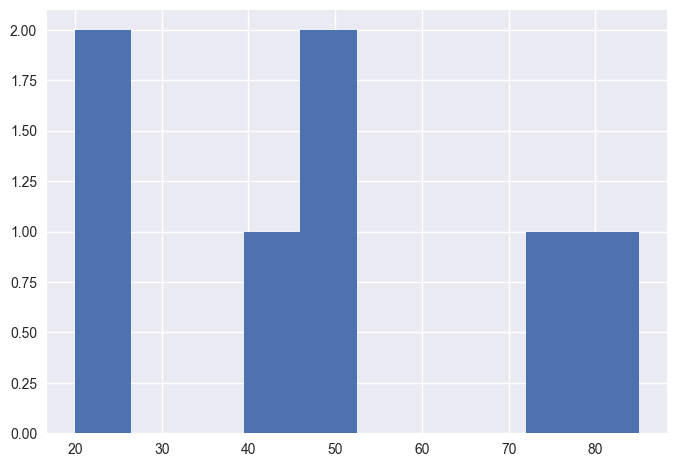

In [169]:
plt.hist(df['feature_val'])